In [10]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
# from mesostat.stat.machinelearning import binary_classifier
# from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.pandas_helper import merge_df_from_dict
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.utils.plotting import imshow

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity, rstest_twosided
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [6]:
significantCellsSelectorDatatype = {}

for datatype in ['raw', 'deconv']:
    signCellsMaintenance = SignificantCells('significant_cells_'+datatype+'_mt.h5').get_cells_by_mouse()
    signCellsReward = SignificantCells('significant_cells_'+datatype+'_enc_reward.h5').get_cells_by_mouse()

    significantCellsSelectorDatatype[datatype] = {
        'None' : None,
        'Maintenance' : signCellsMaintenance,
        'Reward' : signCellsReward
    }

# 1. Neuron-Time-Average

**Goal**: Attempt to predict L/R and C/M from mean activity over trial

**VERY IMPORTANT**: When we compare significant cells, we must compare exactly the same cells in each condition. So, we must select all cells significant within that interval/phase

In [13]:
def test_mean_time_and_neurons(dataDB, datatype, selector, condition, signCellsMouseDict=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    testResults = []
    
    fig, ax = plt.subplots(ncols=nMice, figsize=(4*nMice, 4))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        
        if signCellsMouseDict is not None:
            channelFilter = signCellsMouseDict
            nChannels = len(signCellsMouseDict[mousename])
        else:
            channelFilter = None
            nChannels = dataDB.get_nchannel(mousename, datatype)
            
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "r", selector, {}, channelFilter=signCellsMouseDict)]

        meanVals = [np.mean(mu) for mu in means]
        nTrialsCond = tuple(len(mu) for mu in means)
        negLogPVal = -np.log10(rstest_twosided(*means)[1])
        
                
        testResults += [[mousename, *meanVals, nTrialsCond, nChannels, negLogPVal]]
        ax[iMouse].violinplot(means)
        ax[iMouse].set_title(mousename)
        
    dfRez = pd.DataFrame(testResults, columns=["mouse", *condValues, "nTrials", "nNeurons", "-log10(pval)"])
    display(dfRez)
    plt.show()
    
    return dfRez

(6, 'raw', 'performance', 'None')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,-1.352111,-1.304821,"(20, 133)",88,0.076154
1,m061,-3.832655,-4.771964,"(16, 74)",46,0.205084
2,m065,1.760250,1.534669,"(57, 181)",83,0.167523
3,m066,-0.567327,-0.749272,"(37, 151)",47,0.042835
4,m067,-3.713452,-3.061955,"(43, 154)",49,0.030914
5,m068,6.154690,7.486306,"(63, 175)",28,0.248347


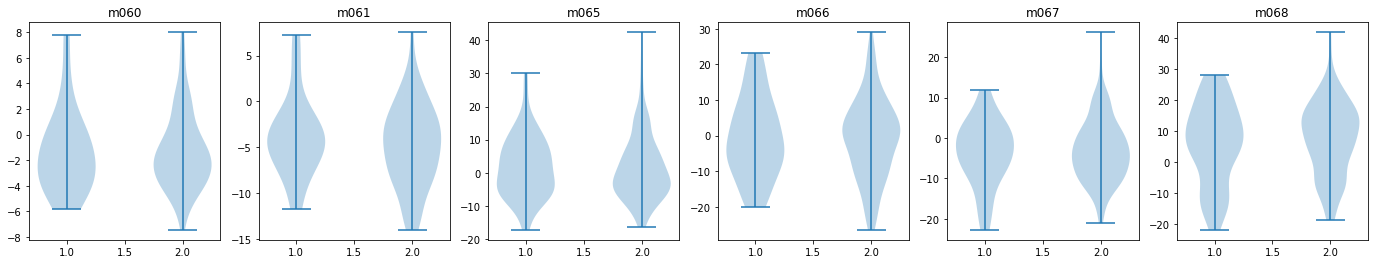

(6, 'raw', 'performance', 'Maintenance')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.096903,0.603253,"(20, 133)",30,0.215368
1,m061,-5.870027,-8.063016,"(16, 74)",20,0.220840
2,m065,-1.527284,-2.210444,"(57, 181)",33,0.241280
3,m066,-6.950179,-5.667766,"(37, 151)",21,0.287947
4,m067,-4.852962,-4.385186,"(43, 154)",24,0.034291
5,m068,-0.446240,0.354197,"(63, 175)",12,0.200937


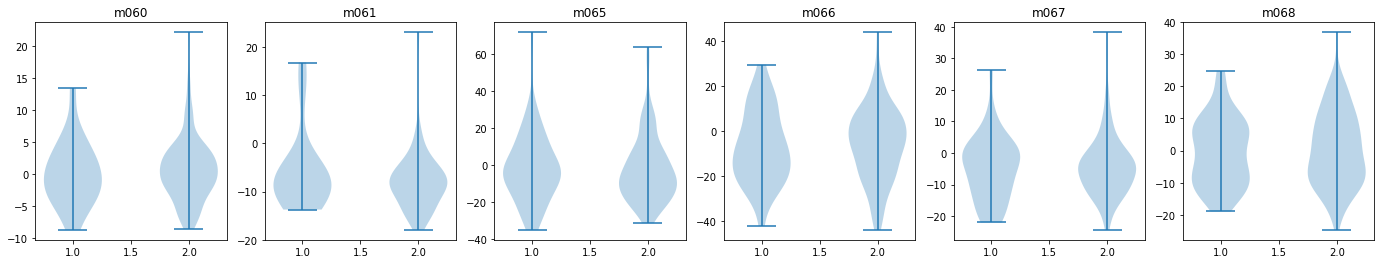

(6, 'raw', 'performance', 'Reward')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,-4.640415,-5.444023,"(20, 133)",28,0.340319
1,m061,-6.424481,-5.706052,"(16, 74)",15,0.346299
2,m065,16.268063,19.566631,"(57, 181)",17,0.813921
3,m066,9.817494,11.242552,"(37, 151)",9,0.226003
4,m067,-2.978872,-1.830474,"(43, 154)",9,0.155086
5,m068,-0.647395,-0.347333,"(63, 175)",10,0.439738


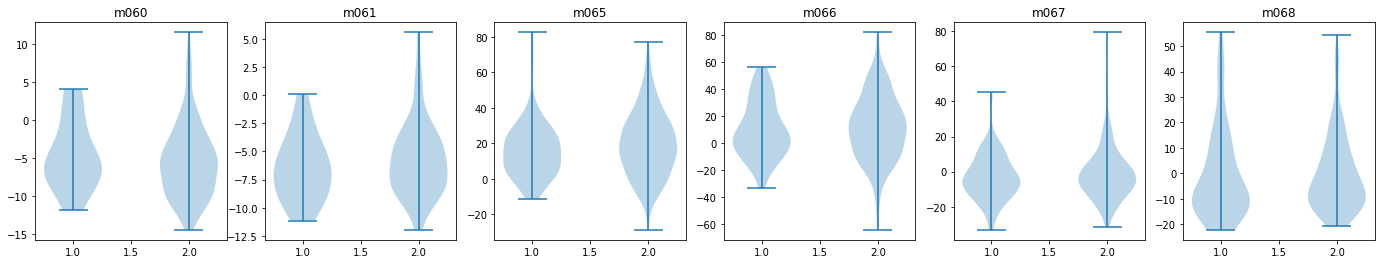

(6, 'raw', 'direction', 'None')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,-1.367706,-1.250469,"(79, 74)",88,0.028059
1,m061,-3.478127,-5.731825,"(45, 45)",46,1.687018
2,m065,-0.898628,4.204672,"(122, 116)",83,4.009997
3,m066,-3.151123,1.341818,"(86, 102)",47,2.233111
4,m067,-3.481470,-2.970908,"(90, 107)",49,0.222437
5,m068,6.606099,7.727506,"(126, 112)",28,0.310361


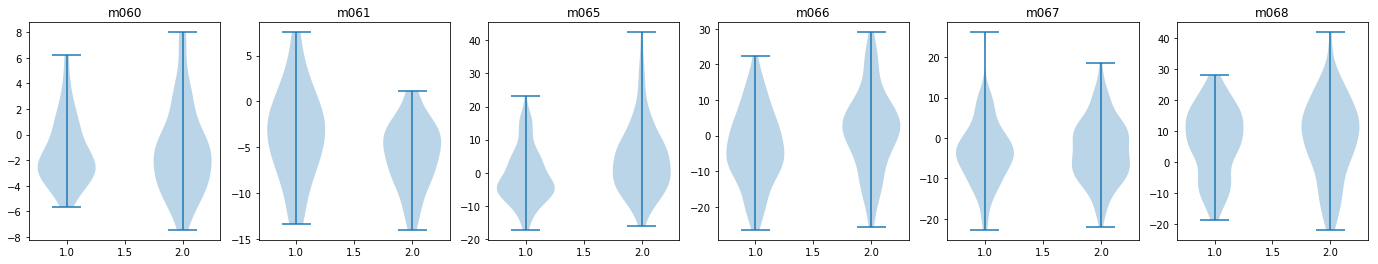

(6, 'raw', 'direction', 'Maintenance')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,1.544197,-0.538121,"(79, 74)",30,2.454361
1,m061,-5.938318,-9.407984,"(45, 45)",20,1.687018
2,m065,-6.373684,2.503827,"(122, 116)",33,3.666835
3,m066,-8.368526,-3.855843,"(86, 102)",21,1.175671
4,m067,-5.500335,-3.635195,"(90, 107)",24,0.686879
5,m068,-0.792356,1.193823,"(126, 112)",12,0.733961


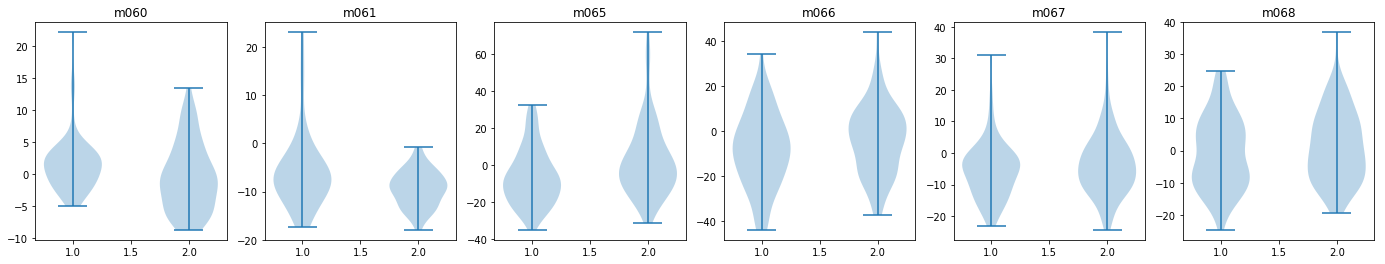

(6, 'raw', 'direction', 'Reward')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,-6.363777,-4.244932,"(79, 74)",28,2.333835
1,m061,-5.568681,-6.098864,"(45, 45)",15,0.536926
2,m065,20.392231,17.077480,"(122, 116)",17,1.070715
3,m066,6.957899,14.338169,"(86, 102)",9,1.831631
4,m067,-2.371093,-1.837253,"(90, 107)",9,0.196342
5,m068,0.713340,-1.709374,"(126, 112)",10,0.720795


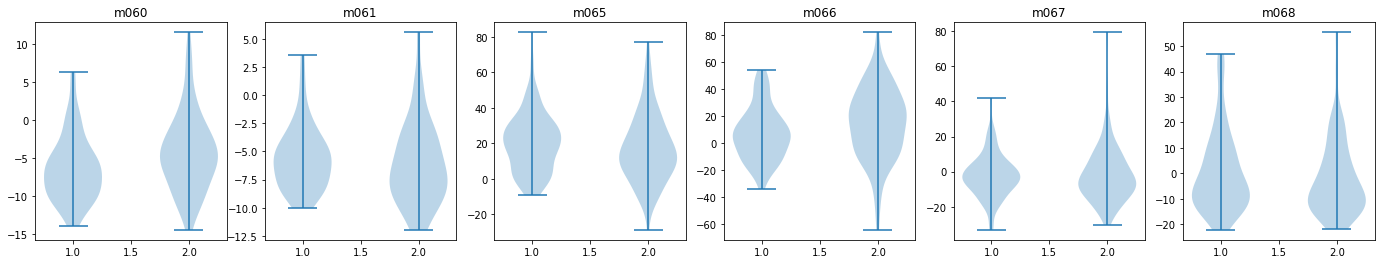

(6, 'deconv', 'performance', 'None')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.067759,0.067734,"(20, 133)",88,0.096210
1,m061,0.084562,0.082701,"(16, 74)",46,0.220840
2,m065,0.140185,0.137333,"(57, 181)",83,0.044947
3,m066,0.145734,0.132018,"(37, 151)",47,0.985166
4,m067,0.096563,0.098013,"(43, 154)",49,0.201053
5,m068,0.105800,0.114815,"(63, 175)",28,1.424139


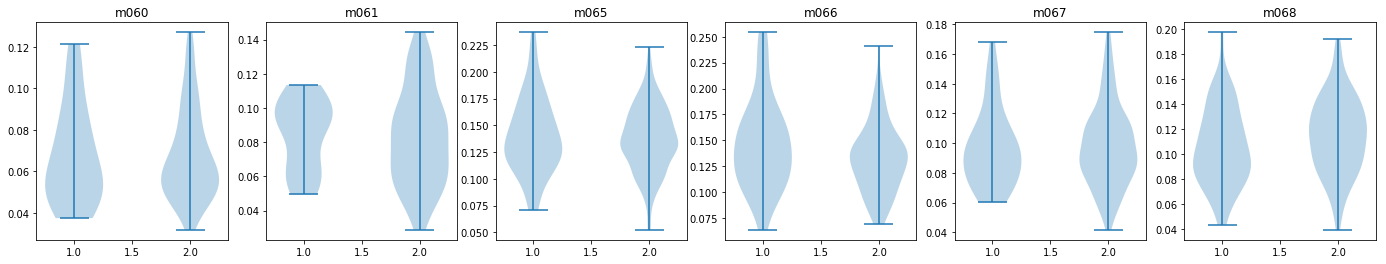

(6, 'deconv', 'performance', 'Maintenance')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.077018,0.076110,"(20, 133)",52,0.054689
1,m061,0.088082,0.088394,"(16, 74)",26,0.005520
2,m065,0.173419,0.168804,"(57, 181)",43,0.127425
3,m066,0.162849,0.148332,"(37, 151)",22,0.364334
4,m067,0.101151,0.101684,"(43, 154)",38,0.155086
5,m068,0.088690,0.101253,"(63, 175)",11,1.397096


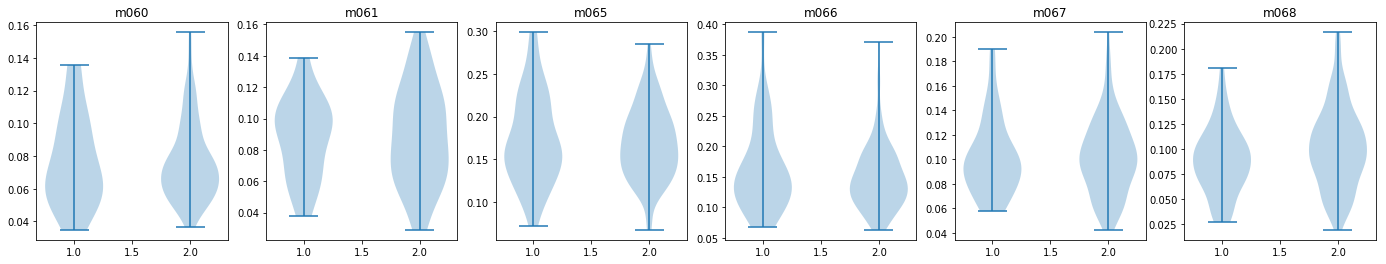

(6, 'deconv', 'performance', 'Reward')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.055368,0.054639,"(20, 133)",40,0.061039
1,m061,0.069121,0.070823,"(16, 74)",8,0.028301
2,m065,0.087994,0.090115,"(57, 181)",21,0.286836
3,m066,0.106835,0.113320,"(37, 151)",15,0.142161
4,m067,0.124054,0.129313,"(43, 154)",13,0.502430
5,m068,0.092106,0.095525,"(63, 175)",14,0.344340


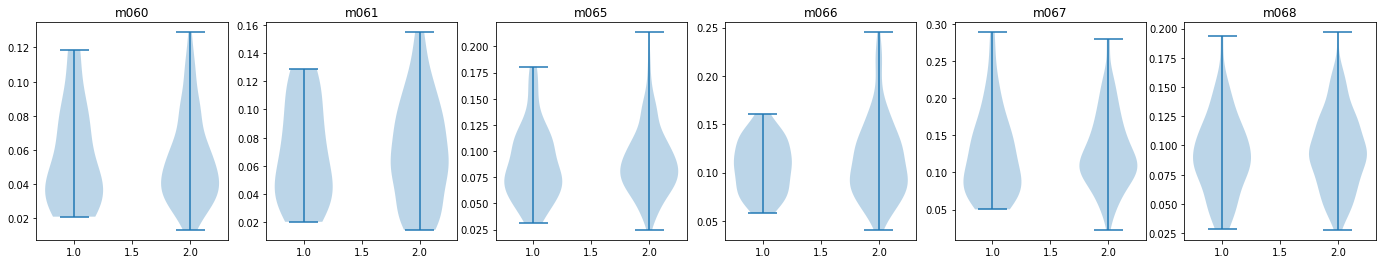

(6, 'deconv', 'direction', 'None')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.066050,0.069540,"(79, 74)",88,0.266923
1,m061,0.090792,0.075272,"(45, 45)",46,2.205782
2,m065,0.130920,0.145479,"(122, 116)",83,3.202687
3,m066,0.137470,0.132397,"(86, 102)",47,0.374757
4,m067,0.098657,0.096890,"(90, 107)",49,0.378318
5,m068,0.110011,0.115149,"(126, 112)",28,0.898548


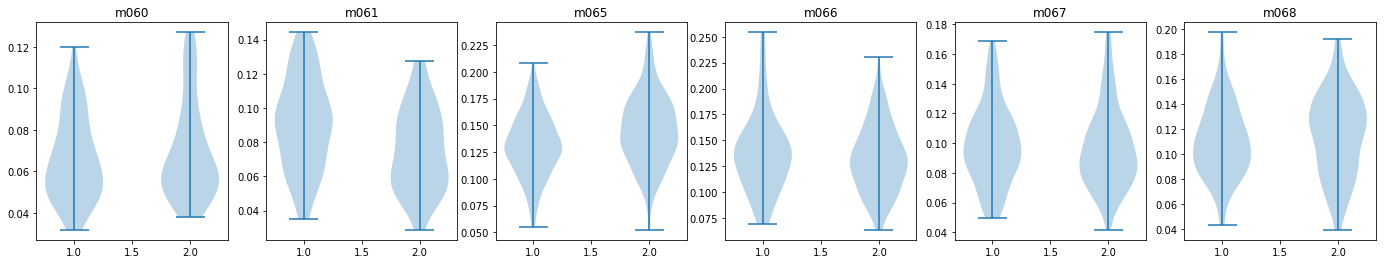

(6, 'deconv', 'direction', 'Maintenance')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.074199,0.078396,"(79, 74)",52,0.327093
1,m061,0.099045,0.077633,"(45, 45)",26,3.335973
2,m065,0.157487,0.182974,"(122, 116)",43,4.615987
3,m066,0.157978,0.145466,"(86, 102)",22,0.822652
4,m067,0.103064,0.100308,"(90, 107)",38,0.584144
5,m068,0.097362,0.098563,"(126, 112)",11,0.020396


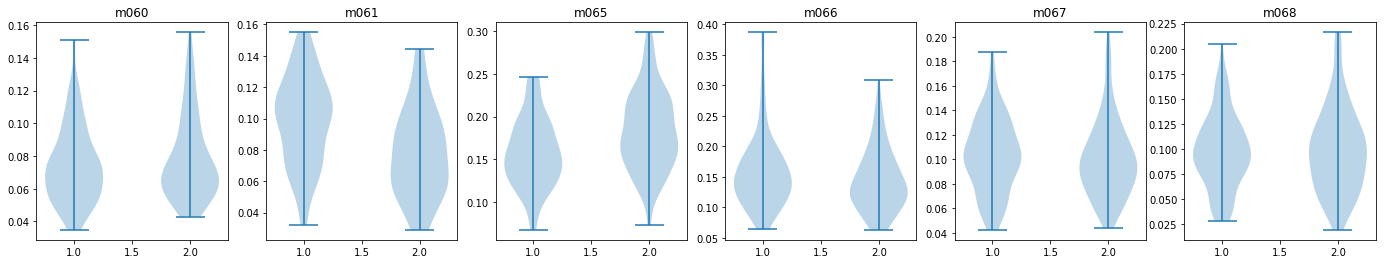

(6, 'deconv', 'direction', 'Reward')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.049279,0.060559,"(79, 74)",40,2.834518
1,m061,0.075867,0.065174,"(45, 45)",8,0.861412
2,m065,0.087428,0.091900,"(122, 116)",21,0.426567
3,m066,0.118934,0.106234,"(86, 102)",15,1.594134
4,m067,0.131654,0.125230,"(90, 107)",13,0.573553
5,m068,0.093151,0.096273,"(126, 112)",14,0.377844


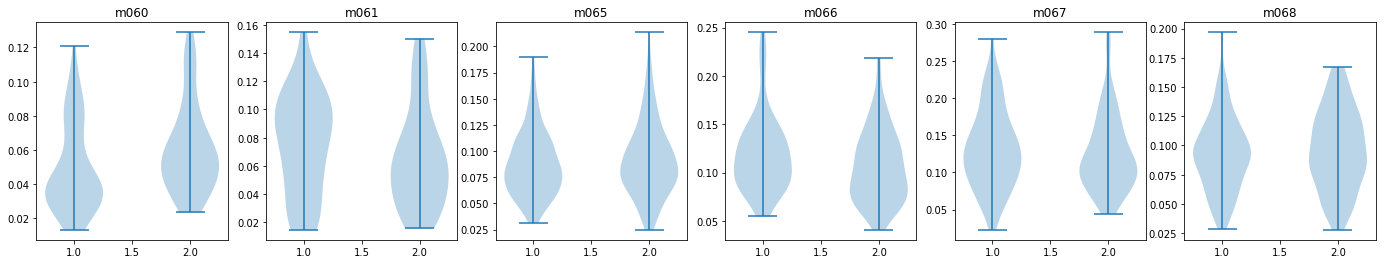

(7, 'raw', 'performance', 'None')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.594007,0.698953,"(20, 133)",88,0.046342
1,m061,1.368240,0.013844,"(16, 74)",46,0.583296
2,m065,3.728965,3.915123,"(57, 181)",83,0.158291
3,m066,6.515552,4.765013,"(37, 151)",47,0.396591
4,m067,1.395481,1.700767,"(43, 154)",49,0.033163
5,m068,-4.668049,-4.780780,"(63, 175)",28,0.119979


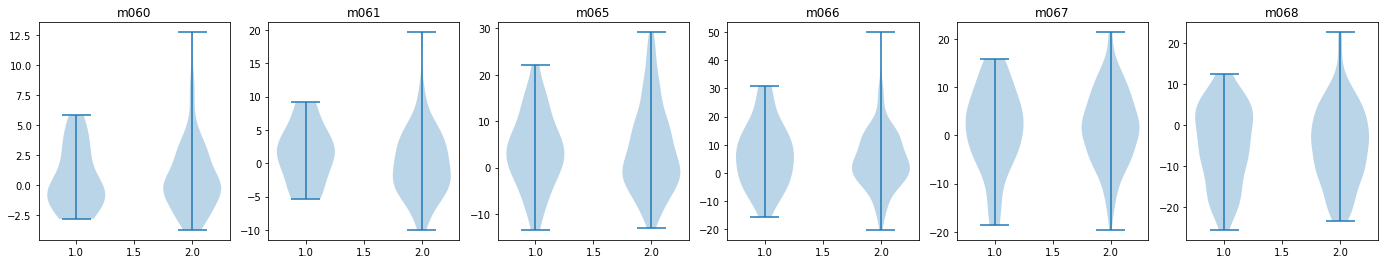

(7, 'raw', 'performance', 'Maintenance')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,5.478730,6.937772,"(20, 133)",30,0.331024
1,m061,4.365733,3.325695,"(16, 74)",20,0.292841
2,m065,13.895354,12.697438,"(57, 181)",33,0.257357
3,m066,18.463407,15.758774,"(37, 151)",21,0.321574
4,m067,4.134185,5.752410,"(43, 154)",24,0.430228
5,m068,3.081080,2.672389,"(63, 175)",12,0.285769


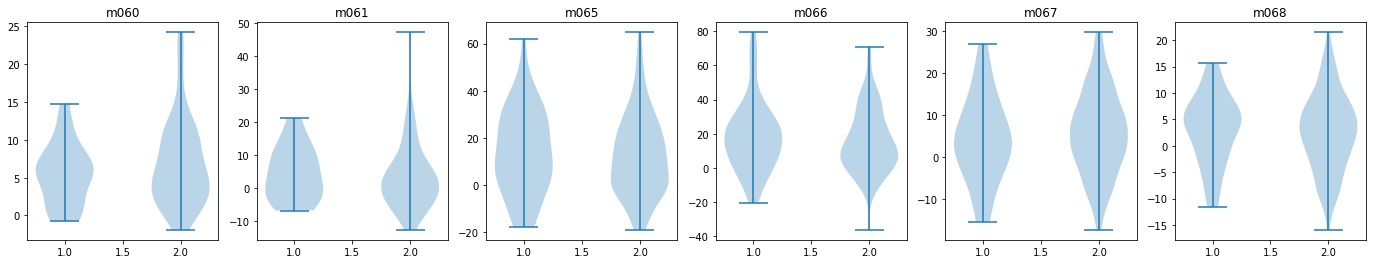

(7, 'raw', 'performance', 'Reward')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,1.524406,1.894252,"(20, 133)",28,0.087209
1,m061,-0.041043,-1.491811,"(16, 74)",15,0.462310
2,m065,1.278470,5.361856,"(57, 181)",17,1.273289
3,m066,-4.591720,2.412382,"(37, 151)",9,1.140449
4,m067,5.552519,8.349002,"(43, 154)",9,0.246839
5,m068,-6.306801,-7.498781,"(63, 175)",10,0.234045


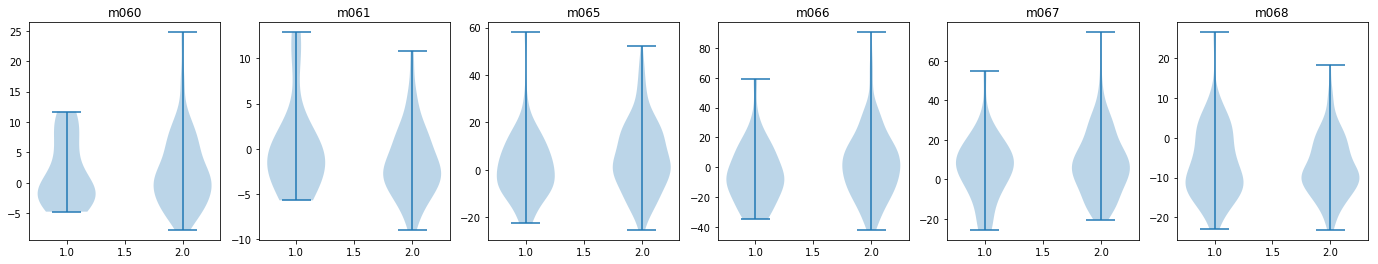

(7, 'raw', 'direction', 'None')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,1.094469,0.248350,"(79, 74)",88,1.333311
1,m061,0.267611,0.241640,"(45, 45)",46,0.050179
2,m065,2.039914,5.795851,"(122, 116)",83,2.897809
3,m066,4.297947,5.793814,"(86, 102)",47,0.357299
4,m067,1.355650,1.868367,"(90, 107)",49,0.122174
5,m068,-5.302298,-4.130661,"(126, 112)",28,0.468088


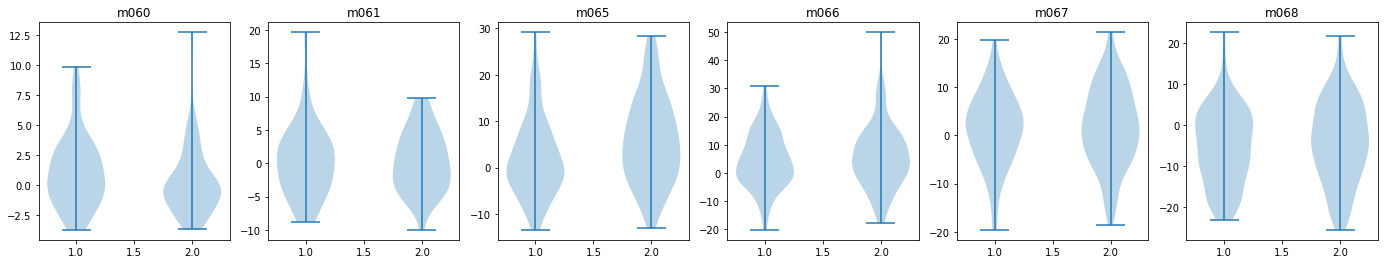

(7, 'raw', 'direction', 'Maintenance')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,7.922361,5.492321,"(79, 74)",30,2.221222
1,m061,4.004480,3.016702,"(45, 45)",20,0.037891
2,m065,9.804385,16.328763,"(122, 116)",33,2.141977
3,m066,16.459600,16.148974,"(86, 102)",21,0.121478
4,m067,5.018835,5.719121,"(90, 107)",24,0.013684
5,m068,2.243095,3.385233,"(126, 112)",12,0.628795


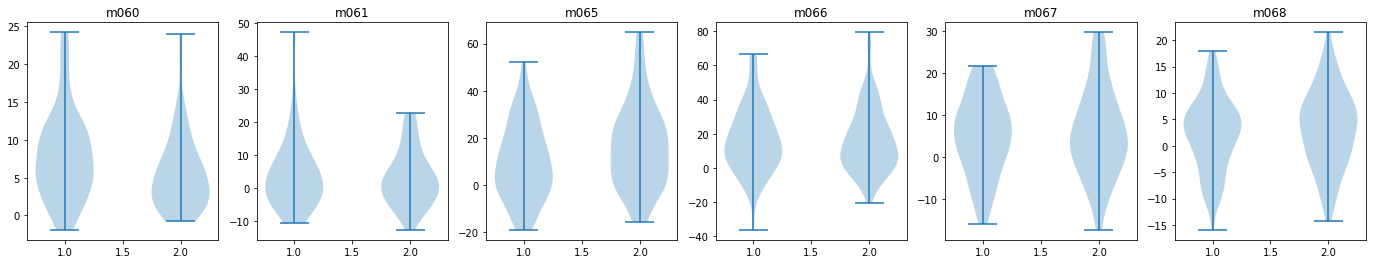

(7, 'raw', 'direction', 'Reward')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,2.565248,1.077960,"(79, 74)",28,1.073052
1,m061,-1.711276,-0.756518,"(45, 45)",15,0.834608
2,m065,5.637588,3.065371,"(122, 116)",17,0.943787
3,m066,-2.806108,4.271582,"(86, 102)",9,1.726491
4,m067,7.079637,8.292871,"(90, 107)",9,0.085976
5,m068,-7.312423,-7.037945,"(126, 112)",10,0.011589


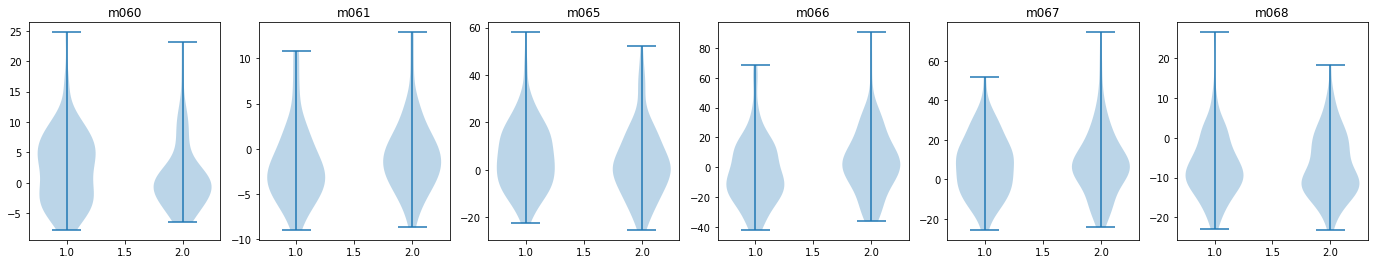

(7, 'deconv', 'performance', 'None')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.081328,0.079091,"(20, 133)",88,0.191427
1,m061,0.119230,0.115873,"(16, 74)",46,0.184570
2,m065,0.129072,0.132361,"(57, 181)",83,0.289238
3,m066,0.147504,0.143915,"(37, 151)",47,0.212474
4,m067,0.121338,0.121481,"(43, 154)",49,0.076656
5,m068,0.076065,0.076176,"(63, 175)",28,0.143658


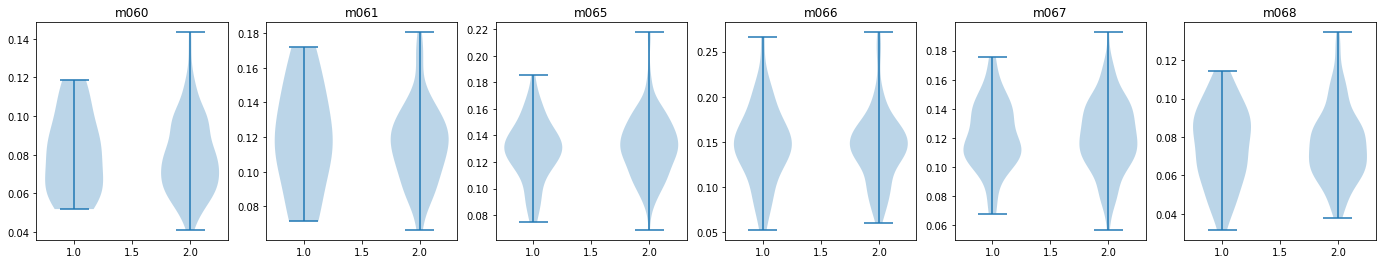

(7, 'deconv', 'performance', 'Maintenance')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.096036,0.094891,"(20, 133)",52,0.078348
1,m061,0.146629,0.146848,"(16, 74)",26,0.016770
2,m065,0.173117,0.178640,"(57, 181)",43,0.394584
3,m066,0.191307,0.183559,"(37, 151)",22,0.415169
4,m067,0.128378,0.131203,"(43, 154)",38,0.430228
5,m068,0.104546,0.107595,"(63, 175)",11,0.430351


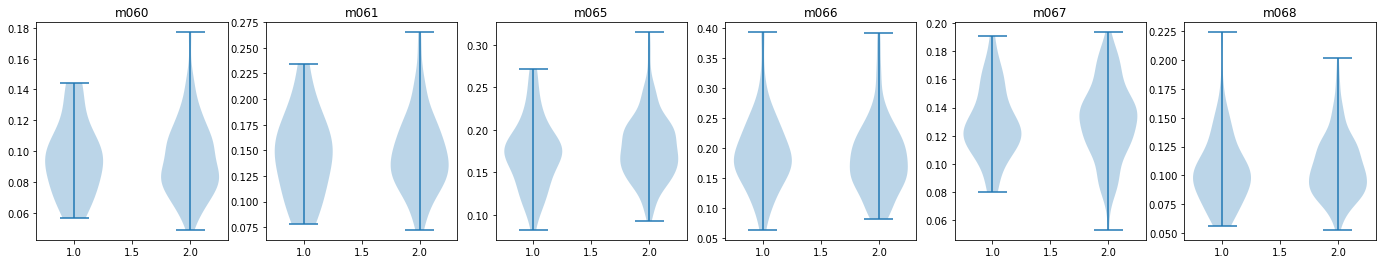

(7, 'deconv', 'performance', 'Reward')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.080545,0.074916,"(20, 133)",40,0.391383
1,m061,0.124637,0.119079,"(16, 74)",8,0.009239
2,m065,0.094950,0.102183,"(57, 181)",21,1.044703
3,m066,0.111770,0.112225,"(37, 151)",15,0.088274
4,m067,0.152941,0.148517,"(43, 154)",13,0.149546
5,m068,0.094692,0.089919,"(63, 175)",14,0.812474


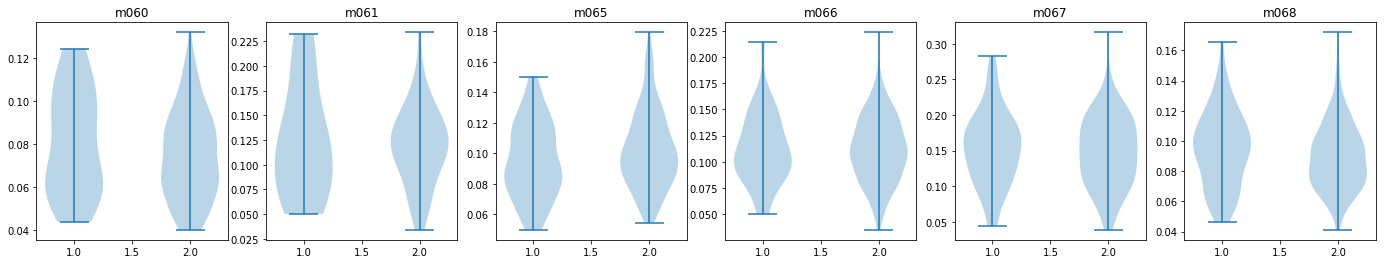

(7, 'deconv', 'direction', 'None')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.081195,0.077450,"(79, 74)",88,0.645559
1,m061,0.117719,0.115221,"(45, 45)",46,0.152129
2,m065,0.129026,0.134252,"(122, 116)",83,0.726649
3,m066,0.147316,0.142349,"(86, 102)",47,0.435654
4,m067,0.122181,0.120834,"(90, 107)",49,0.135475
5,m068,0.074955,0.077488,"(126, 112)",28,0.350083


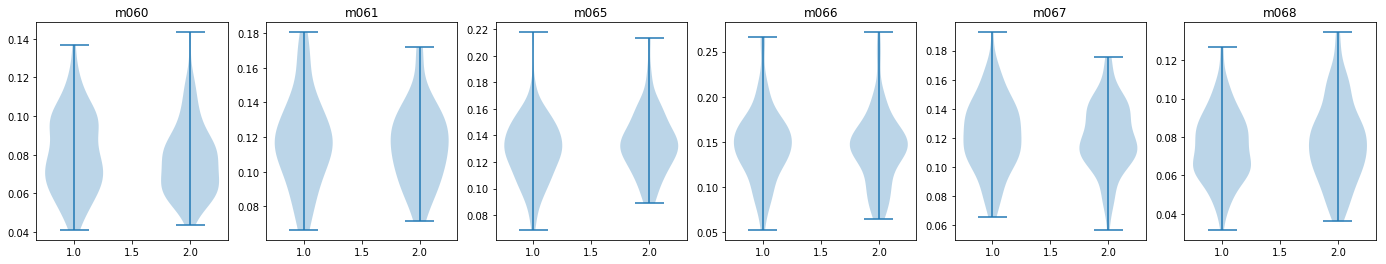

(7, 'deconv', 'direction', 'Maintenance')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.098206,0.091661,"(79, 74)",52,1.173207
1,m061,0.147526,0.146092,"(45, 45)",26,-0.000000
2,m065,0.175591,0.179133,"(122, 116)",43,0.117810
3,m066,0.190495,0.180522,"(86, 102)",22,0.550889
4,m067,0.131502,0.129817,"(90, 107)",38,0.228780
5,m068,0.107570,0.105908,"(126, 112)",11,0.240566


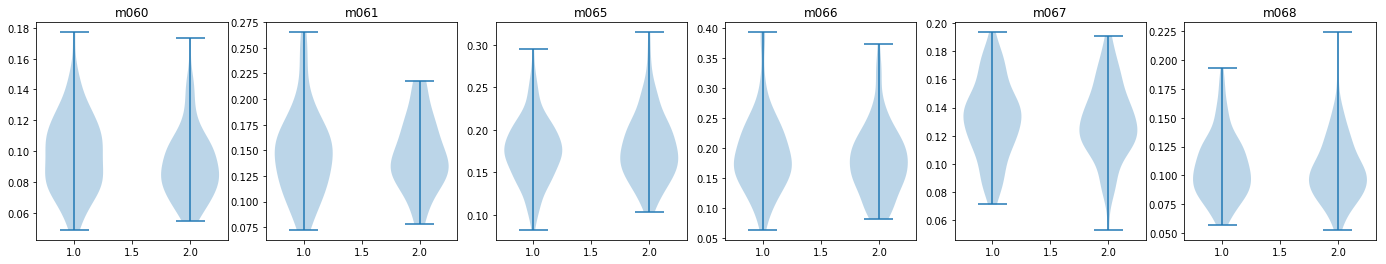

(7, 'deconv', 'direction', 'Reward')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.076382,0.074872,"(79, 74)",40,0.216107
1,m061,0.117463,0.122671,"(45, 45)",8,0.130327
2,m065,0.098672,0.102322,"(122, 116)",21,0.348365
3,m066,0.113520,0.110968,"(86, 102)",15,0.028380
4,m067,0.149012,0.149879,"(90, 107)",13,0.049035
5,m068,0.090994,0.091394,"(126, 112)",14,0.032869


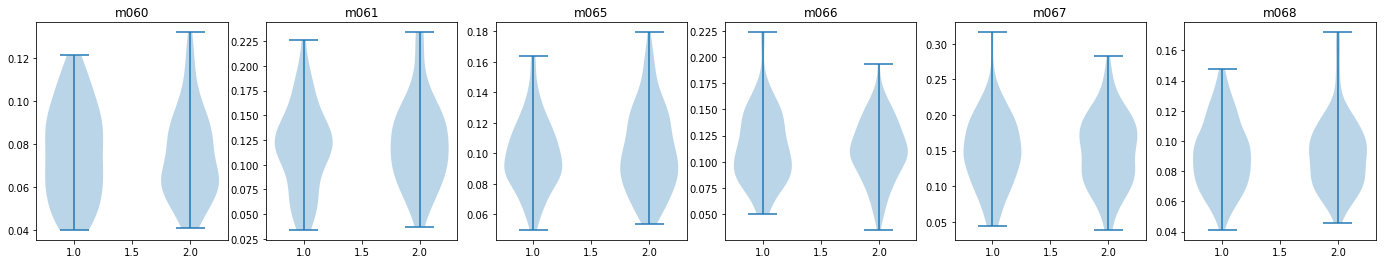

(8, 'raw', 'performance', 'None')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,-0.228939,-0.175410,"(20, 133)",88,0.063172
1,m061,4.508098,4.263194,"(16, 74)",46,0.205084
2,m065,0.343717,1.313618,"(57, 181)",83,0.308678
3,m066,1.090615,4.679963,"(37, 151)",47,1.289406
4,m067,2.136065,2.643752,"(43, 154)",49,0.060960
5,m068,-7.716978,-7.709418,"(63, 175)",28,0.041792


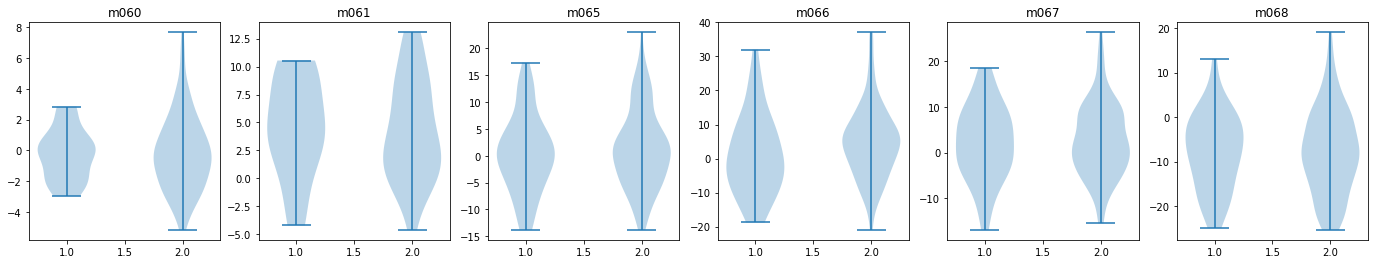

(8, 'raw', 'performance', 'Maintenance')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,1.591441,2.415214,"(20, 133)",30,0.309677
1,m061,9.754521,11.755741,"(16, 74)",20,0.184570
2,m065,15.525945,15.446430,"(57, 181)",33,-0.000000
3,m066,10.417201,19.759203,"(37, 151)",21,2.212475
4,m067,9.116853,9.387787,"(43, 154)",24,0.049193
5,m068,3.723135,4.542524,"(63, 175)",12,0.216783


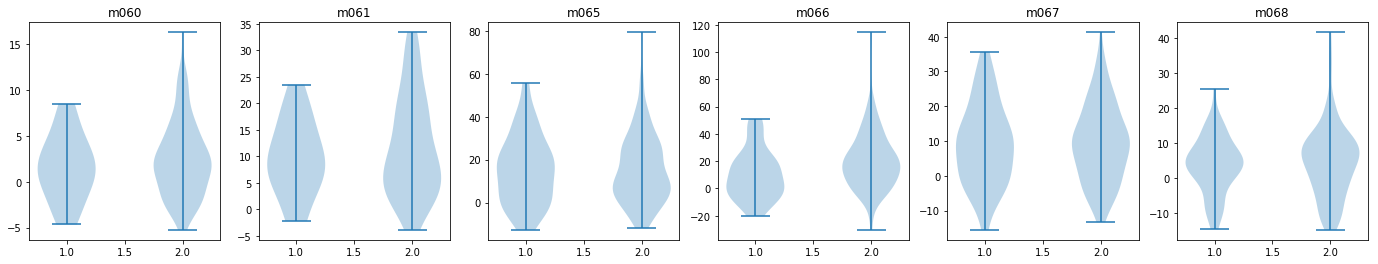

(8, 'raw', 'performance', 'Reward')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,-1.064447,-1.570943,"(20, 133)",28,0.309677
1,m061,2.288712,1.787591,"(16, 74)",15,0.154847
2,m065,-14.553649,-11.257764,"(57, 181)",17,0.967424
3,m066,-11.258305,-10.701574,"(37, 151)",9,0.149806
4,m067,-0.371346,-1.336896,"(43, 154)",9,0.080343
5,m068,-11.230065,-12.256105,"(63, 175)",10,0.501920


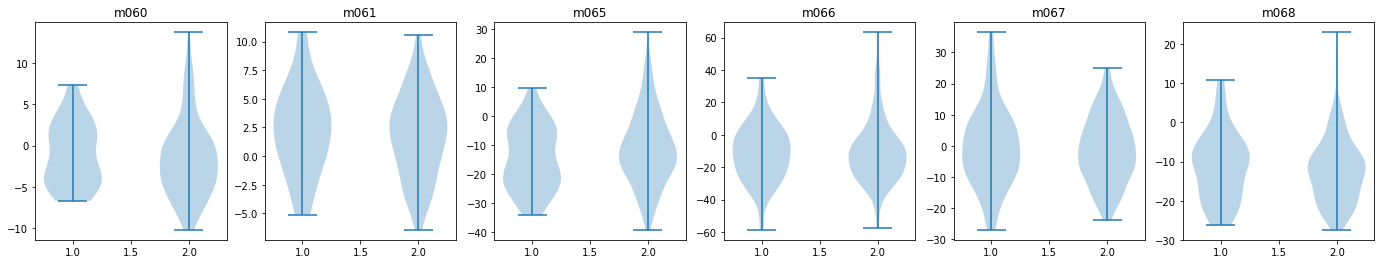

(8, 'raw', 'direction', 'None')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,-0.010146,-0.366307,"(79, 74)",88,0.584966
1,m061,4.056658,4.556806,"(45, 45)",46,0.190080
2,m065,0.221262,1.985886,"(122, 116)",83,1.314343
3,m066,3.588683,4.298044,"(86, 102)",47,0.099547
4,m067,2.420615,2.627413,"(90, 107)",49,0.071702
5,m068,-8.341901,-7.002128,"(126, 112)",28,0.561679


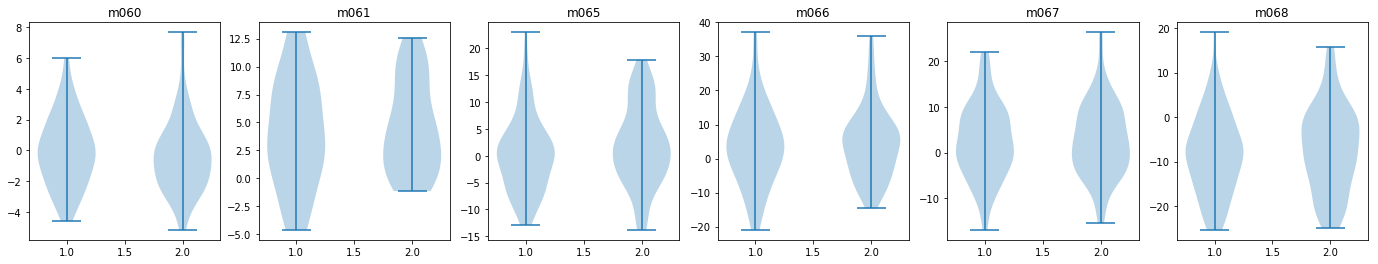

(8, 'raw', 'direction', 'Maintenance')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,2.538830,2.060603,"(79, 74)",30,0.445496
1,m061,11.264932,11.535005,"(45, 45)",20,0.098962
2,m065,14.076475,16.926316,"(122, 116)",33,0.841353
3,m066,17.164891,18.557799,"(86, 102)",21,0.403962
4,m067,9.336642,9.321926,"(90, 107)",24,0.004808
5,m068,3.649409,5.086373,"(126, 112)",12,0.635681


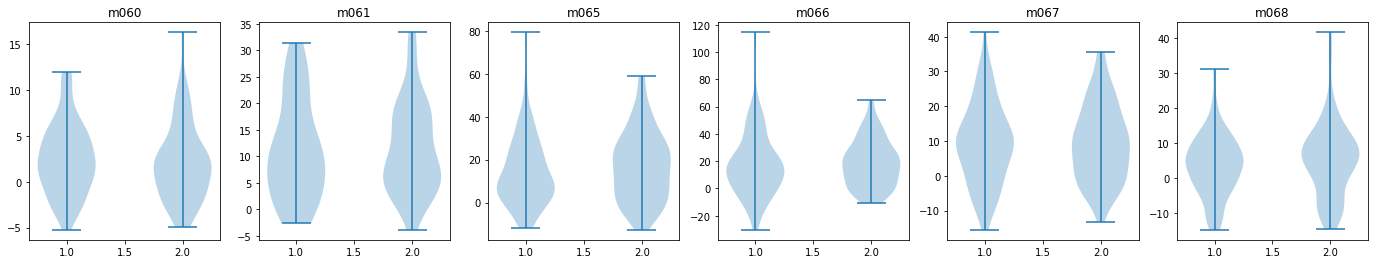

(8, 'raw', 'direction', 'Reward')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,-1.388290,-1.629046,"(79, 74)",28,0.208844
1,m061,1.381830,2.371529,"(45, 45)",15,0.847962
2,m065,-12.122566,-11.967760,"(122, 116)",17,0.074438
3,m066,-11.268947,-10.425153,"(86, 102)",9,0.351023
4,m067,-1.358087,-0.931047,"(90, 107)",9,0.078793
5,m068,-12.444323,-11.467213,"(126, 112)",10,0.062513


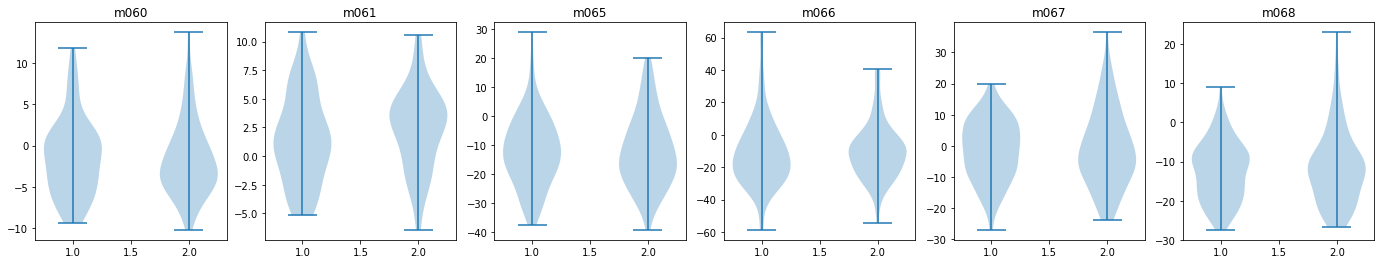

(8, 'deconv', 'performance', 'None')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.068244,0.070614,"(20, 133)",88,0.103052
1,m061,0.112732,0.112255,"(16, 74)",46,0.020582
2,m065,0.111839,0.122343,"(57, 181)",83,3.479329
3,m066,0.129506,0.136277,"(37, 151)",47,1.080180
4,m067,0.116068,0.115500,"(43, 154)",49,0.118559
5,m068,0.079160,0.084600,"(63, 175)",28,1.291450


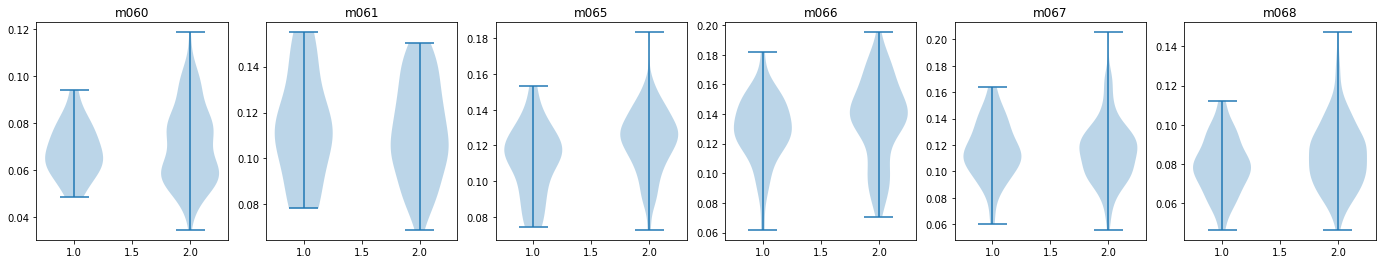

(8, 'deconv', 'performance', 'Maintenance')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.074529,0.077916,"(20, 133)",52,0.188813
1,m061,0.145682,0.150366,"(16, 74)",26,0.205084
2,m065,0.146115,0.161164,"(57, 181)",43,3.497728
3,m066,0.149846,0.164339,"(37, 151)",22,1.870528
4,m067,0.123276,0.124016,"(43, 154)",38,0.025340
5,m068,0.103990,0.113950,"(63, 175)",11,1.978561


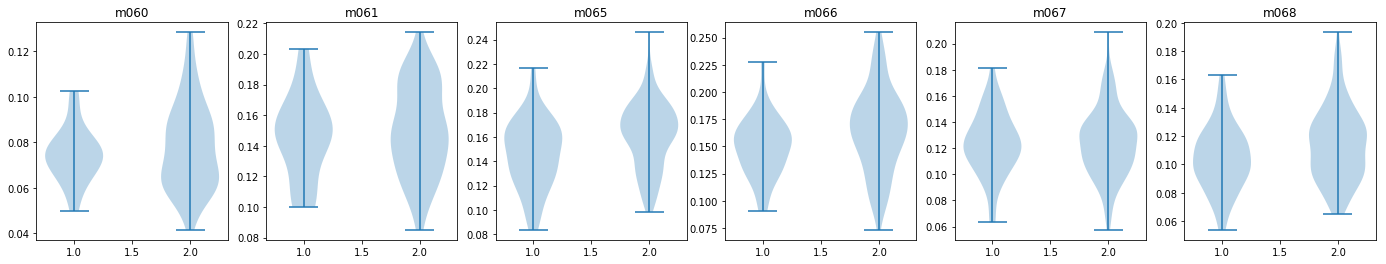

(8, 'deconv', 'performance', 'Reward')


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.076939,0.081934,"(20, 133)",40,0.337211
1,m061,0.130620,0.143339,"(16, 74)",8,0.377297
2,m065,0.097361,0.103584,"(57, 181)",21,0.938438
3,m066,0.115311,0.117886,"(37, 151)",15,0.113902
4,m067,0.135205,0.130974,"(43, 154)",13,0.422681
5,m068,0.099899,0.107151,"(63, 175)",14,1.100181


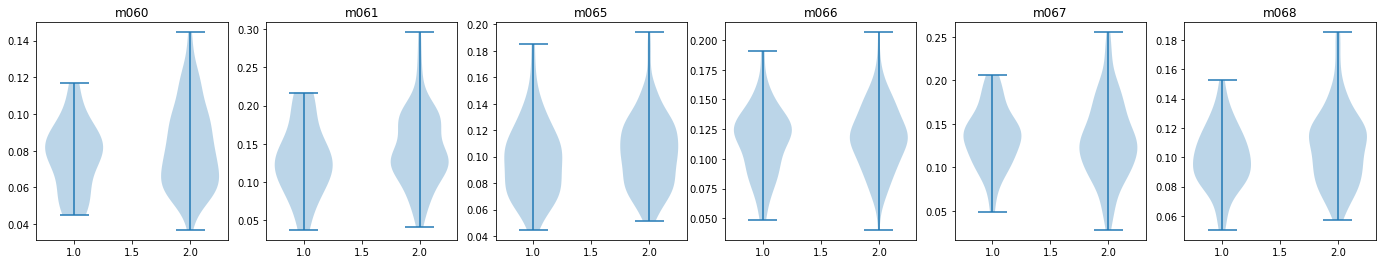

(8, 'deconv', 'direction', 'None')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.071384,0.069152,"(79, 74)",88,0.352273
1,m061,0.111735,0.112944,"(45, 45)",46,0.116190
2,m065,0.118198,0.121542,"(122, 116)",83,0.860150
3,m066,0.137429,0.132850,"(86, 102)",47,0.332430
4,m067,0.114690,0.116410,"(90, 107)",49,0.184224
5,m068,0.081685,0.084820,"(126, 112)",28,0.849325


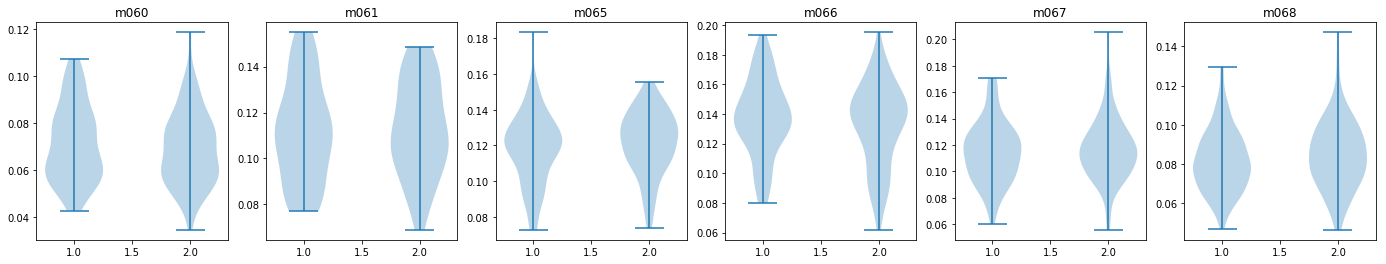

(8, 'deconv', 'direction', 'Maintenance')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.078789,0.076069,"(79, 74)",52,0.345918
1,m061,0.147178,0.151889,"(45, 45)",26,0.441491
2,m065,0.156354,0.158827,"(122, 116)",43,0.371562
3,m066,0.162042,0.161018,"(86, 102)",22,0.066508
4,m067,0.122977,0.124592,"(90, 107)",38,0.094297
5,m068,0.109669,0.113164,"(126, 112)",11,0.519102


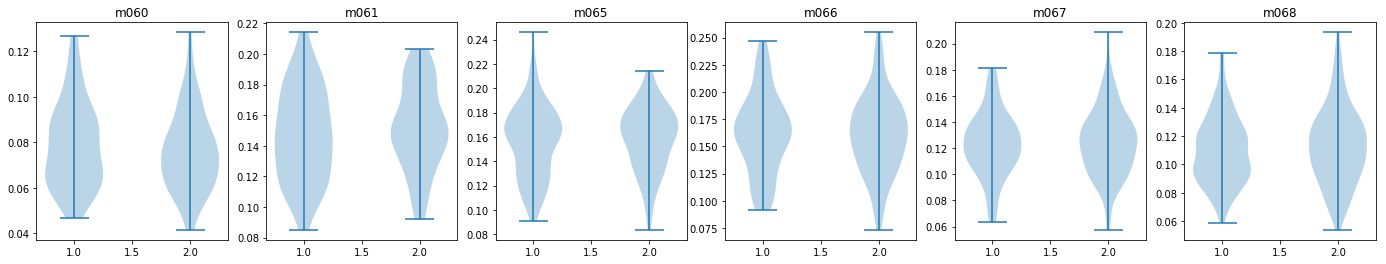

(8, 'deconv', 'direction', 'Reward')


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.082928,0.079523,"(79, 74)",40,0.296515
1,m061,0.137939,0.144217,"(45, 45)",8,0.221914
2,m065,0.099770,0.104537,"(122, 116)",21,1.007163
3,m066,0.118534,0.116405,"(86, 102)",15,0.243230
4,m067,0.131115,0.132557,"(90, 107)",13,0.020002
5,m068,0.103545,0.107129,"(126, 112)",14,0.566933


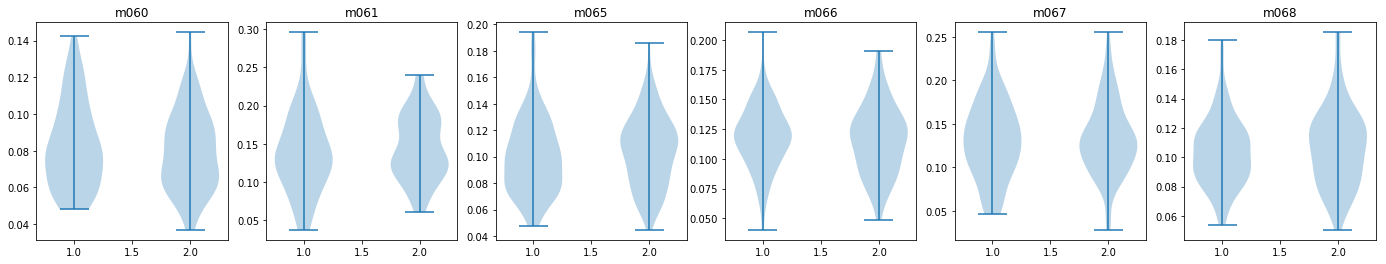

In [14]:
# selector = {"phase" : "Maintenance"}

rezDict = {}
for interval in range(6, 9):
    for datatype in ['raw', 'deconv']:
        for condition in ["performance", "direction"]:
            for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
#                 print(condition, useSignificant)
                keys = (interval, datatype, condition, signCellsName)
                selector = {"interval" : interval}
                print(keys)
                dfRez = test_mean_time_and_neurons(dataDB, datatype, selector, condition, signCellsMouseDict=signCells)
                rezDict[keys] = dfRez                

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDict, ['interval', 'datatype', 'condition', 'filter']))

,interval,datatype,condition,filter,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval),L,R
0,6,raw,performance,None,m060,-1.352111,-1.304821,"(20, 133)",88,0.076154,NaN,NaN
1,6,raw,performance,None,m061,-3.832655,-4.771964,"(16, 74)",46,0.205084,NaN,NaN
2,6,raw,performance,None,m065,1.760250,1.534669,"(57, 181)",83,0.167523,NaN,NaN
3,6,raw,performance,None,m066,-0.567327,-0.749272,"(37, 151)",47,0.042835,NaN,NaN
4,6,raw,performance,None,m067,-3.713452,-3.061955,"(43, 154)",49,0.030914,NaN,NaN
5,6,raw,performance,None,m068,6.154690,7.486306,"(63, 175)",28,0.248347,NaN,NaN
6,6,raw,performance,Maintenance,m060,0.096903,0.603253,"(20, 133)",30,0.215368,NaN,NaN
7,6,raw,performance,Maintenance,m061,-5.870027,-8.063016,"(16, 74)",20,0.220840,NaN,NaN
8,6,raw,performance,Maintenance,m065,-1.527284,-2.210444,"(57, 181)",33,0.241280,NaN,NaN
9,6,raw,performance,Maintenance,m066,-6.950179,-5.667766,"(37, 151)",21,0.287947,NaN,NaN


# 2 Time-Average

**Goal**: Attempt to predict LR/CM from average activities of individual cells.
* Count predictive cells in each mouse, phase/interval

In [20]:
def test_mean_time(dataDB, datatype, selector, condition, nTest=1000, pval=0.01, signCellsMouseDict=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig1, ax1 = plt.subplots(ncols=nMice, figsize=(4*nMice, 4), tight_layout=True)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        
        if signCellsMouseDict is not None:
            channelFilter = signCellsMouseDict
            nCells = len(signCellsMouseDict[mousename])
        else:
            channelFilter = None
            nCells = dataDB.get_nchannel(mousename, datatype)
        
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "pr", selector, {}, channelFilter=channelFilter)]
            
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval)
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 2)]]
        
        ax1[iMouse].plot(sorted(-np.log10(pValByCell)))
        ax1[iMouse].axhline(y=2, linestyle="--", color='r')
        ax1[iMouse].set_xlabel("cell index, sorted")
        ax1[iMouse].set_ylabel("-log10(pVal)")
        ax1[iMouse].set_title(mousename)
    
    rezDf = pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "-log10(pval)"])
    display(rezDf)
        
    plt.show()
    
    return rezDf

6 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,4,88,1.92
1,m061,0,46,0.00
2,m065,0,83,0.00
3,m066,0,47,-0.00
4,m067,1,49,0.41
5,m068,0,28,-0.00


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


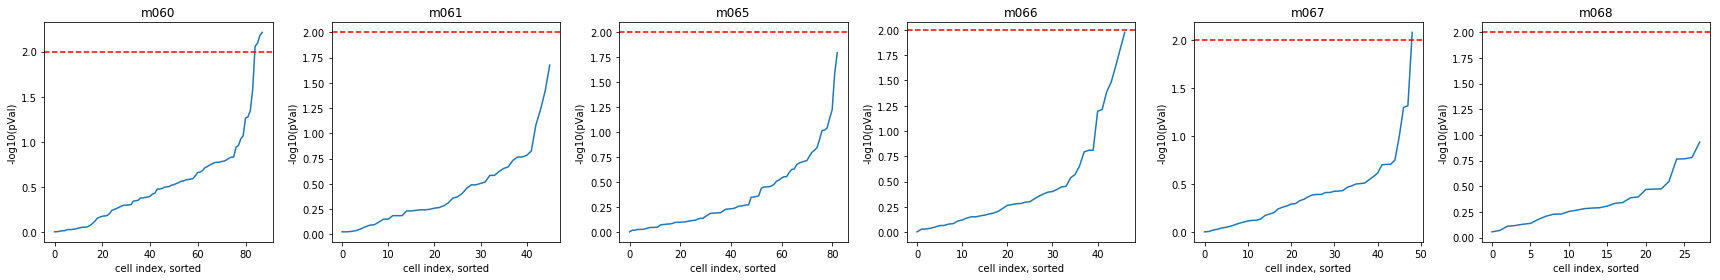

6 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,30,0.58
1,m061,0,20,0.00
2,m065,0,33,-0.00
3,m066,0,21,0.00
4,m067,1,24,0.67
5,m068,0,12,0.00


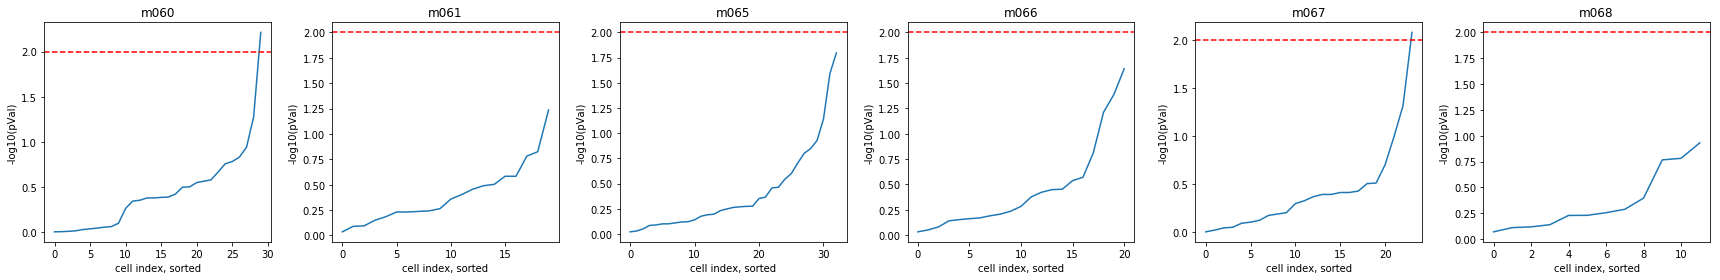

6 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,2,28,1.5
1,m061,0,15,-0.0
2,m065,0,17,-0.0
3,m066,0,9,0.0
4,m067,0,9,0.0
5,m068,0,10,-0.0


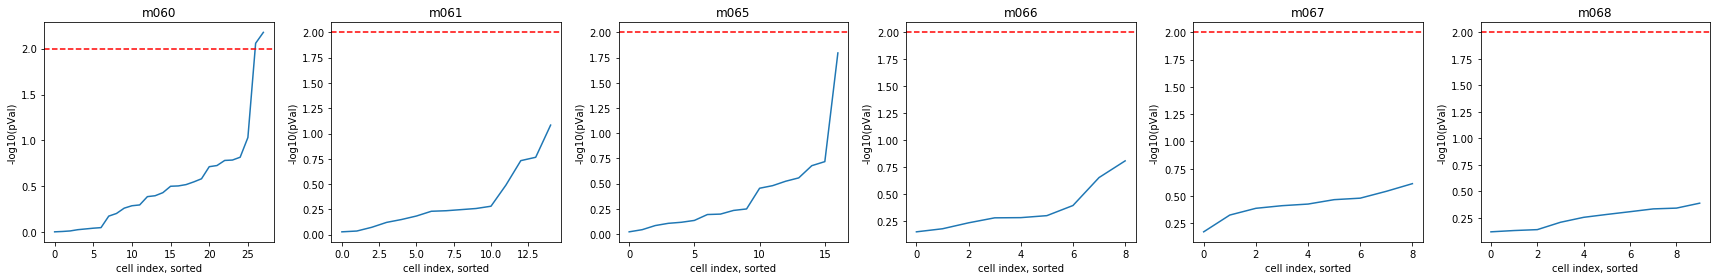

6 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,16,88,15.13
1,m061,1,46,0.43
2,m065,18,83,18.40
3,m066,7,47,6.35
4,m067,0,49,0.00
5,m068,0,28,-0.00


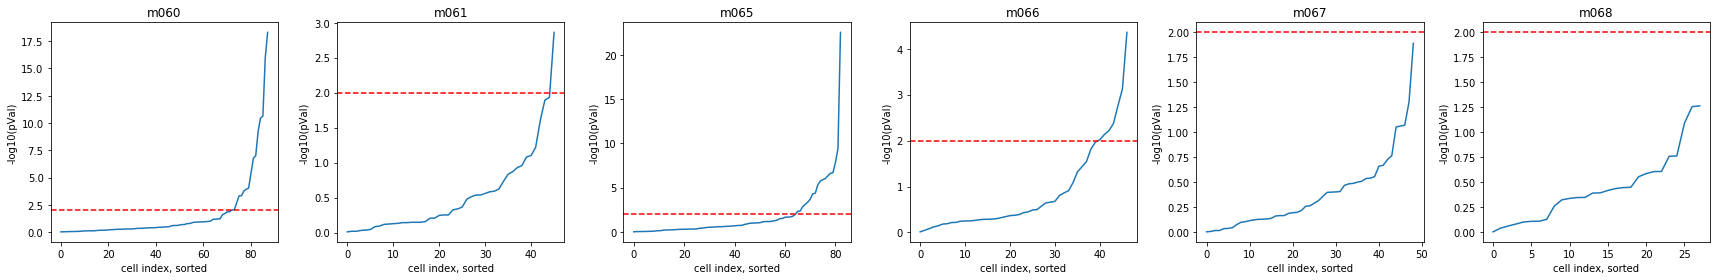

6 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,5,30,4.94
1,m061,0,20,0.00
2,m065,7,33,7.47
3,m066,5,21,5.75
4,m067,0,24,0.00
5,m068,0,12,0.00


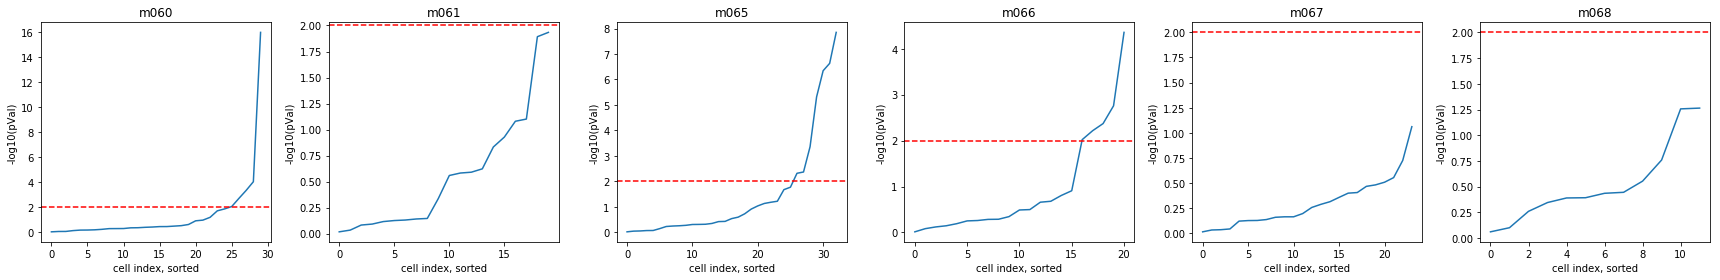

6 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,4,28,3.77
1,m061,1,15,0.85
2,m065,7,17,9.75
3,m066,1,9,1.06
4,m067,0,9,0.00
5,m068,0,10,-0.00


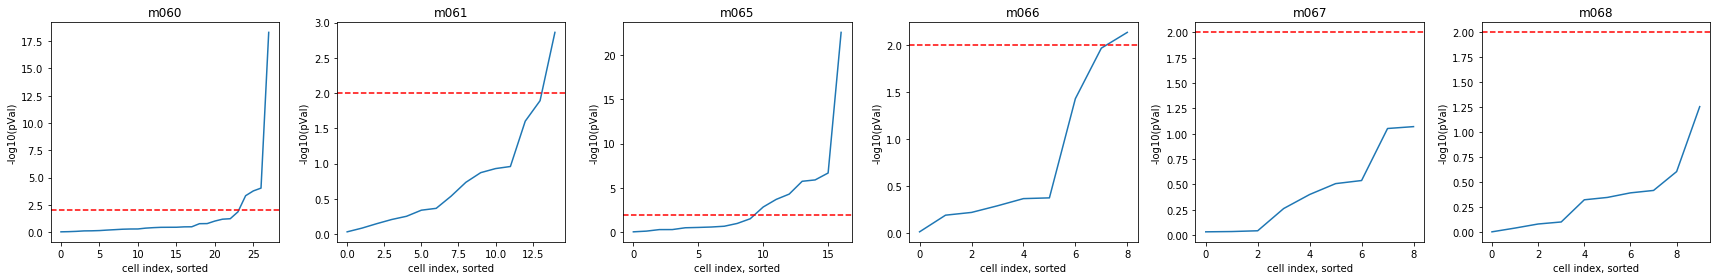

6 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,88,0.23
1,m061,0,46,0.00
2,m065,1,83,0.25
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,0,28,-0.00


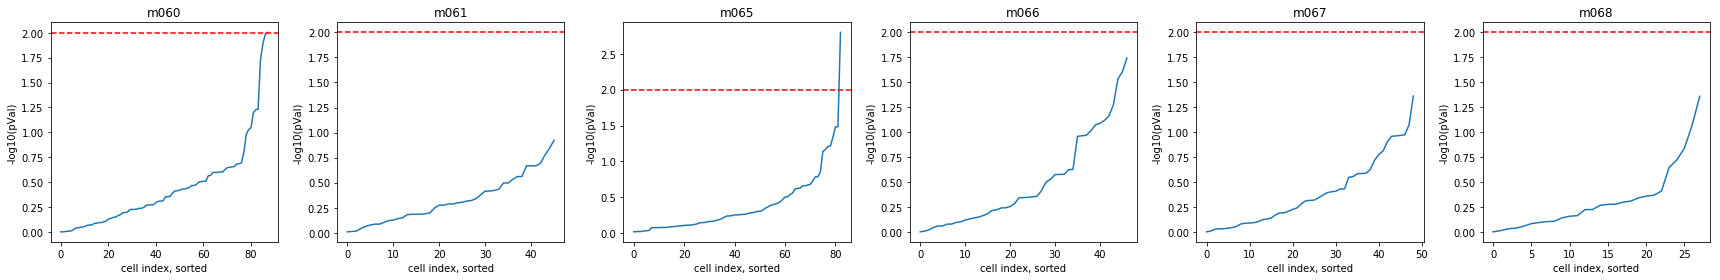

6 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,52,0.39
1,m061,0,26,-0.00
2,m065,0,43,-0.00
3,m066,0,22,-0.00
4,m067,0,38,-0.00
5,m068,0,11,0.00


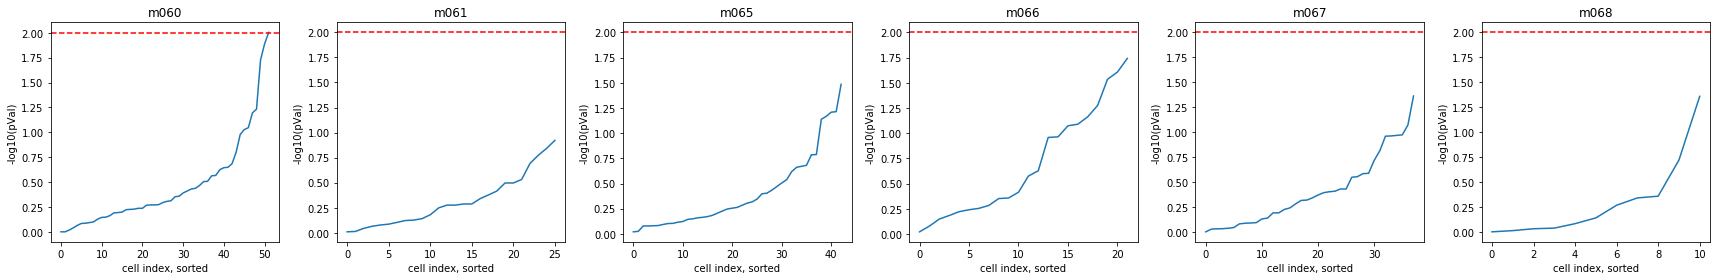

6 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,40,0.48
1,m061,0,8,0.00
2,m065,0,21,0.00
3,m066,0,15,-0.00
4,m067,0,13,0.00
5,m068,0,14,-0.00


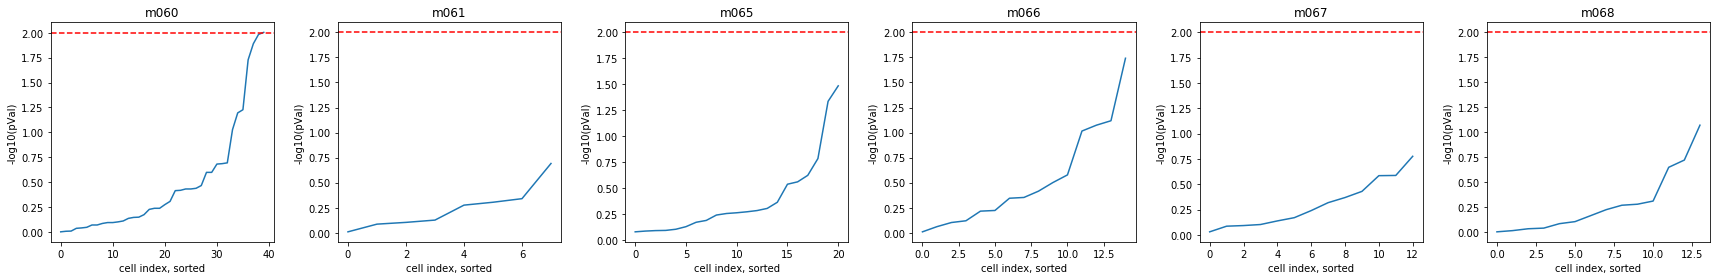

6 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,18,88,17.91
1,m061,1,46,0.43
2,m065,9,83,6.77
3,m066,2,47,1.09
4,m067,0,49,0.00
5,m068,2,28,1.50


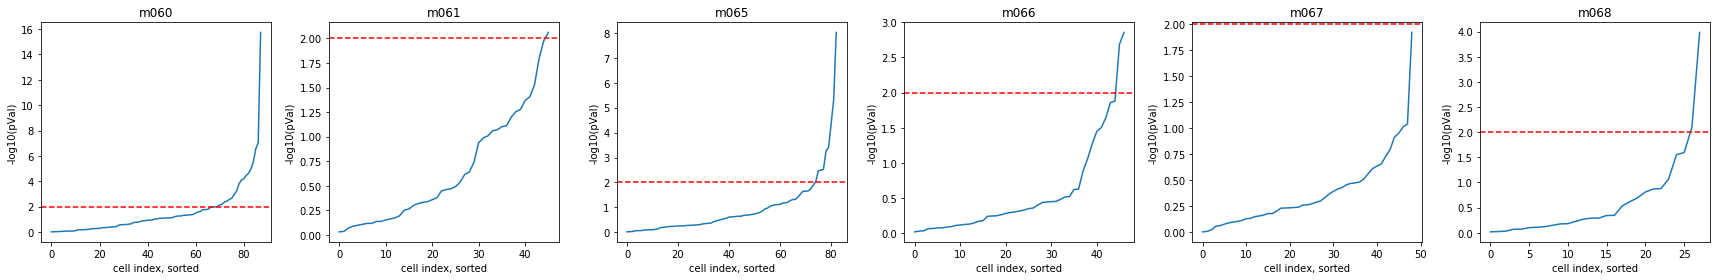

6 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,10,52,9.97
1,m061,0,26,-0.00
2,m065,7,43,6.63
3,m066,2,22,1.69
4,m067,0,38,-0.00
5,m068,0,11,0.00


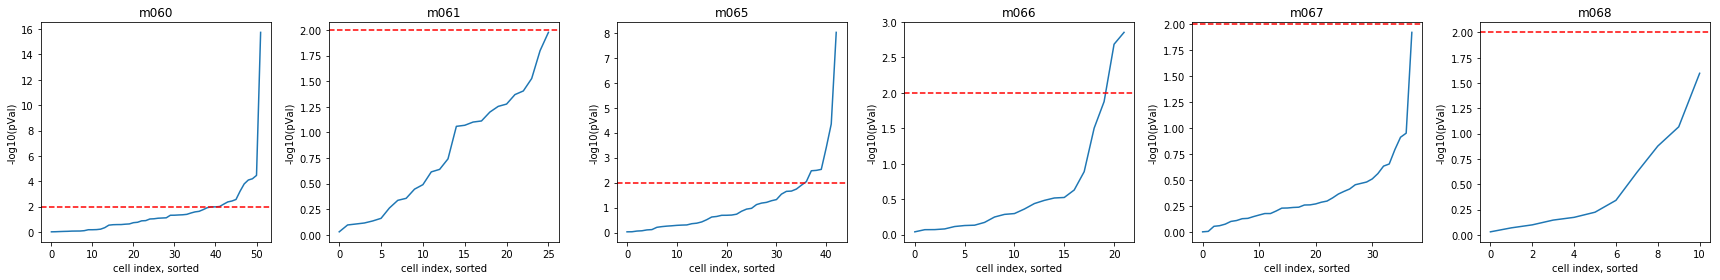

6 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,6,40,5.54
1,m061,0,8,0.00
2,m065,0,21,0.00
3,m066,1,15,0.85
4,m067,0,13,0.00
5,m068,1,14,0.88


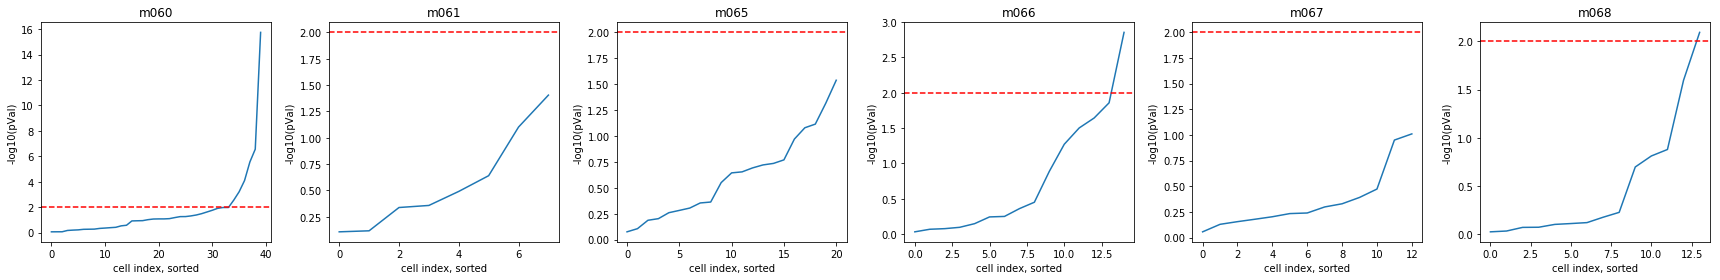

7 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,88,0.23
1,m061,1,46,0.43
2,m065,0,83,0.00
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,0,28,-0.00


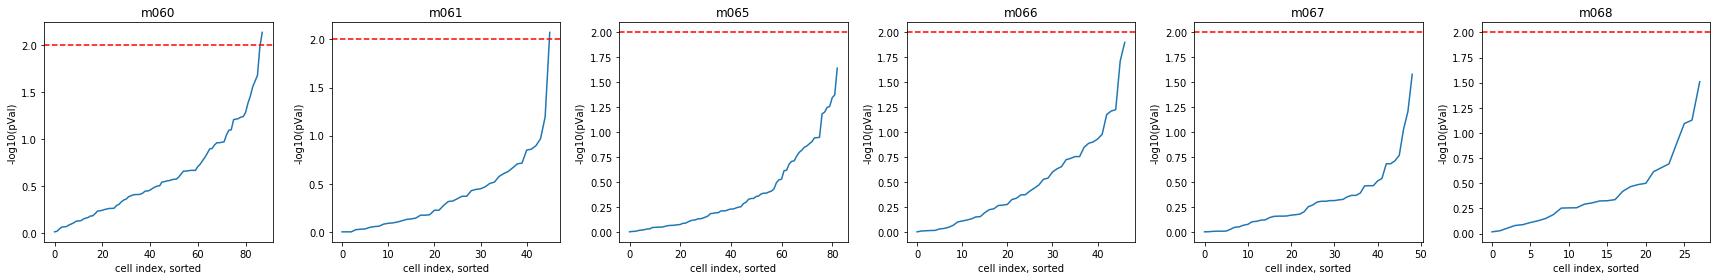

7 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,30,0.58
1,m061,0,20,0.00
2,m065,0,33,-0.00
3,m066,0,21,0.00
4,m067,0,24,0.00
5,m068,0,12,0.00


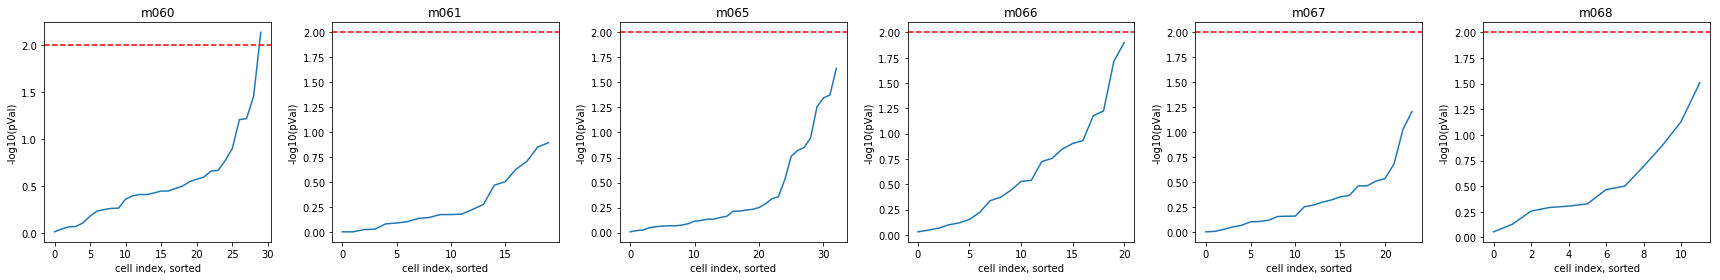

7 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,28,0.61
1,m061,1,15,0.85
2,m065,0,17,-0.00
3,m066,0,9,0.00
4,m067,0,9,0.00
5,m068,0,10,-0.00


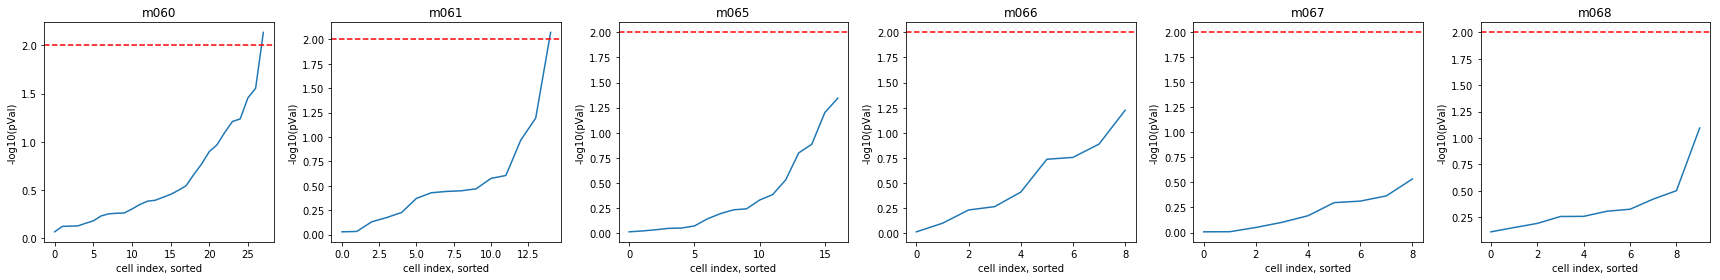

7 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,7,88,4.50
1,m061,2,46,1.11
2,m065,13,83,11.56
3,m066,2,47,1.09
4,m067,0,49,0.00
5,m068,0,28,-0.00


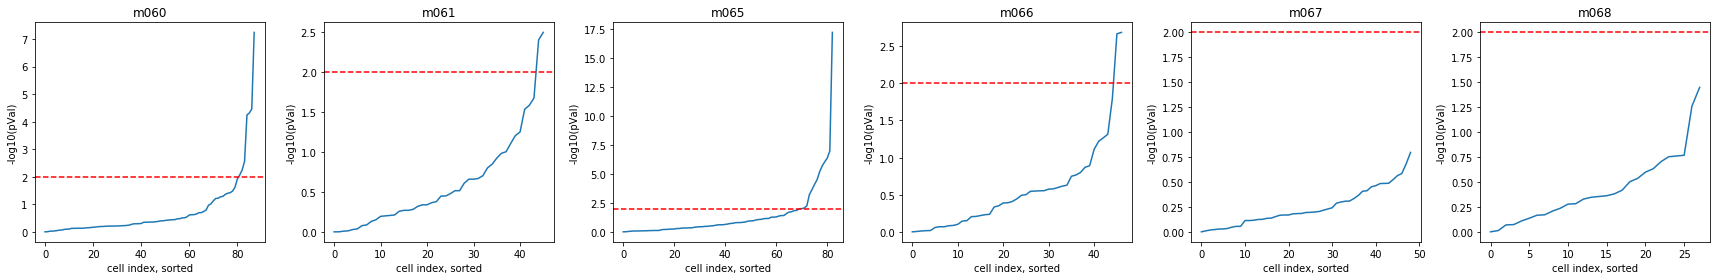

7 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,3,30,2.48
1,m061,1,20,0.74
2,m065,5,33,4.73
3,m066,1,21,0.72
4,m067,0,24,0.00
5,m068,0,12,0.00


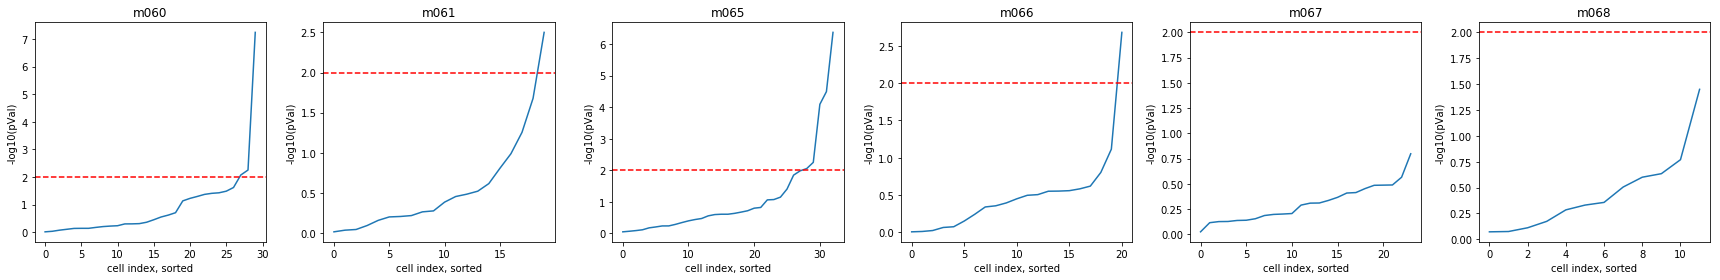

7 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,4,28,3.77
1,m061,1,15,0.85
2,m065,6,17,7.95
3,m066,0,9,0.00
4,m067,0,9,0.00
5,m068,0,10,-0.00


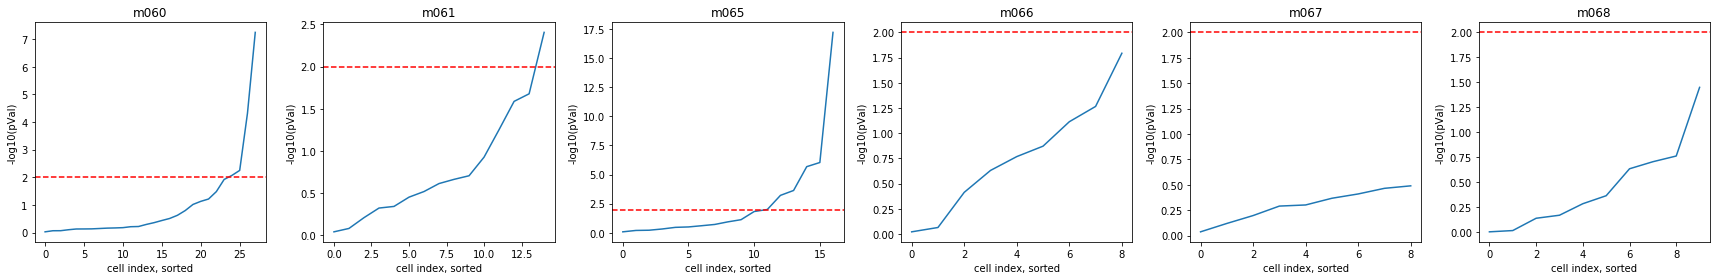

7 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,3,88,1.23
1,m061,0,46,0.00
2,m065,0,83,0.00
3,m066,1,47,0.42
4,m067,0,49,0.00
5,m068,1,28,0.61


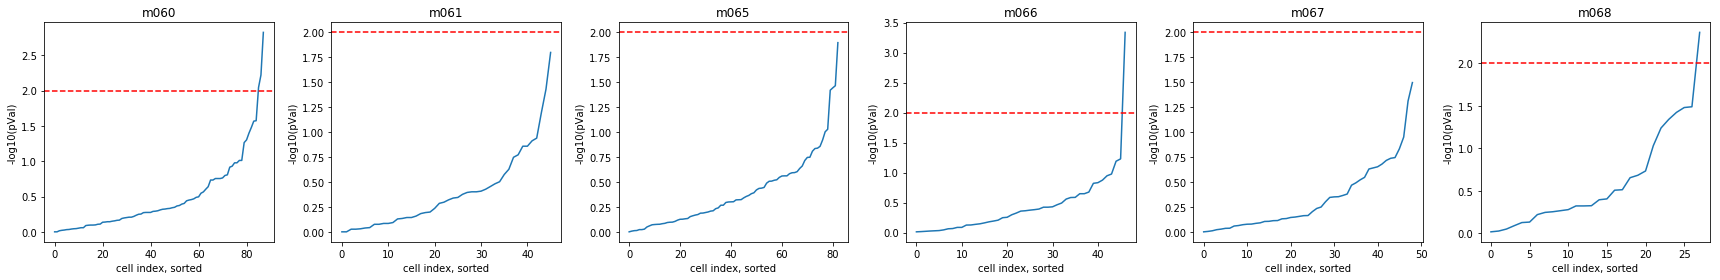

7 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,3,52,1.81
1,m061,0,26,-0.00
2,m065,0,43,-0.00
3,m066,1,22,0.70
4,m067,0,38,-0.00
5,m068,0,11,0.00


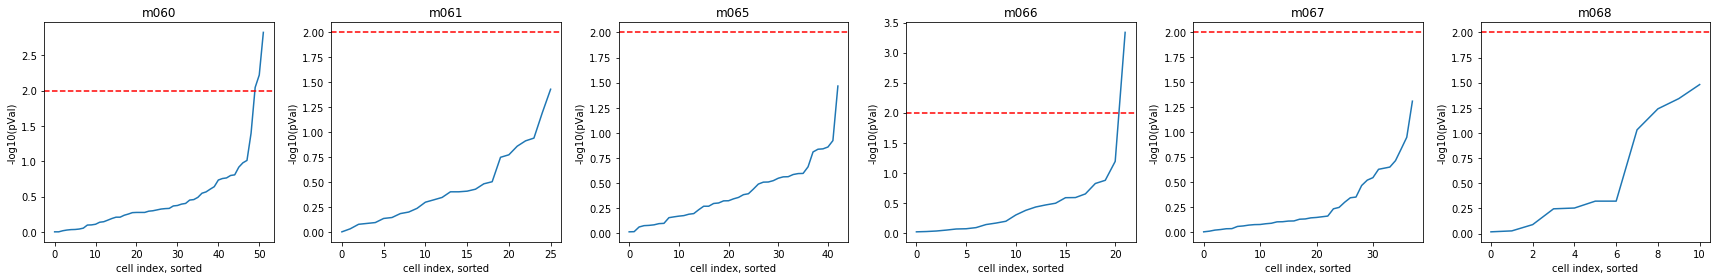

7 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,40,0.48
1,m061,0,8,0.00
2,m065,0,21,0.00
3,m066,1,15,0.85
4,m067,0,13,0.00
5,m068,0,14,-0.00


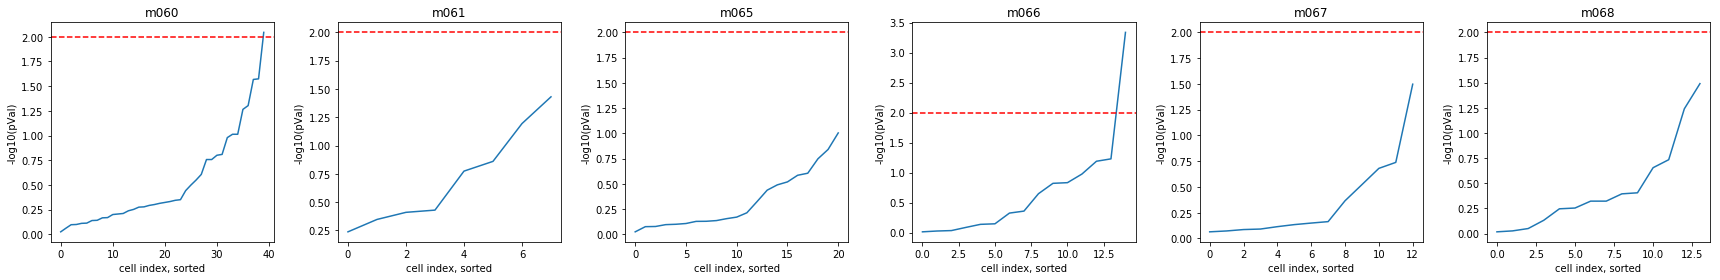

7 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,3,88,1.23
1,m061,1,46,0.43
2,m065,1,83,0.25
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,1,28,0.61


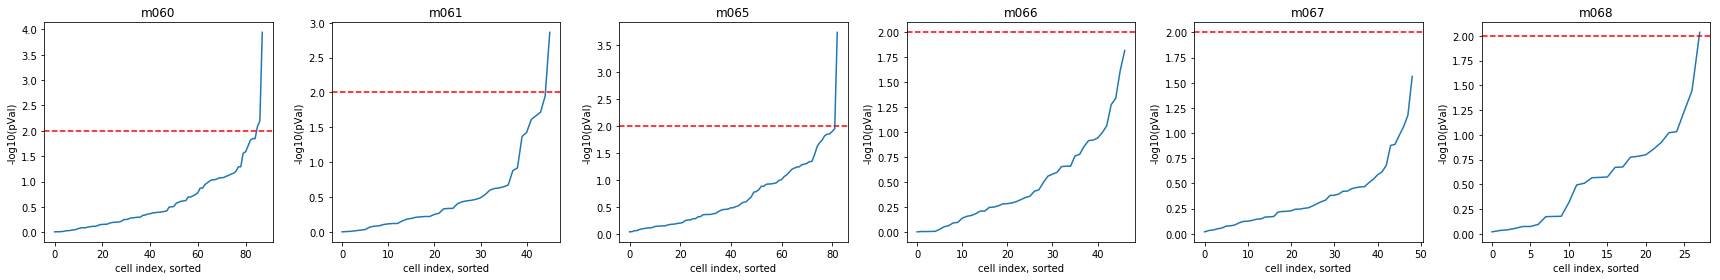

7 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,52,0.39
1,m061,1,26,0.64
2,m065,1,43,0.45
3,m066,0,22,-0.00
4,m067,0,38,-0.00
5,m068,0,11,0.00


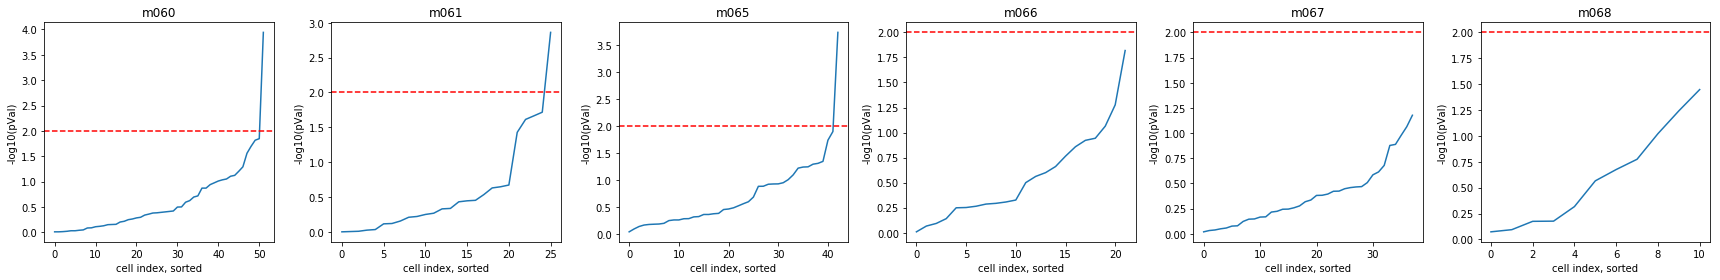

7 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,3,40,2.13
1,m061,1,8,1.11
2,m065,0,21,0.00
3,m066,0,15,-0.00
4,m067,0,13,0.00
5,m068,0,14,-0.00


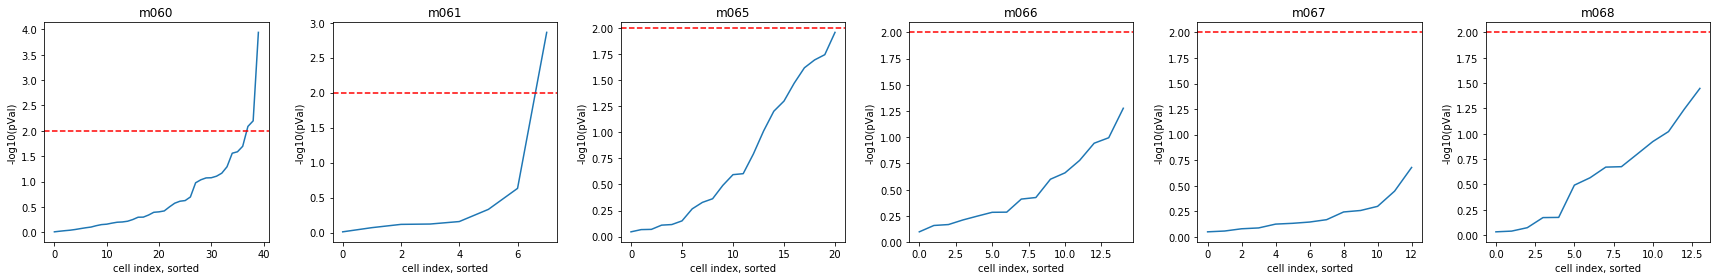

8 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,88,0.23
1,m061,0,46,0.00
2,m065,0,83,0.00
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,0,28,-0.00


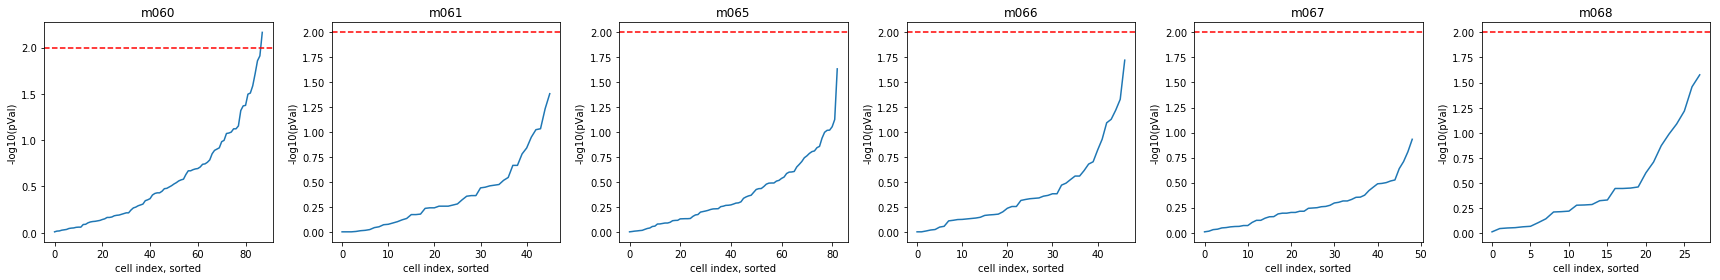

8 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,30,-0.0
1,m061,0,20,0.0
2,m065,0,33,-0.0
3,m066,0,21,0.0
4,m067,0,24,0.0
5,m068,0,12,0.0


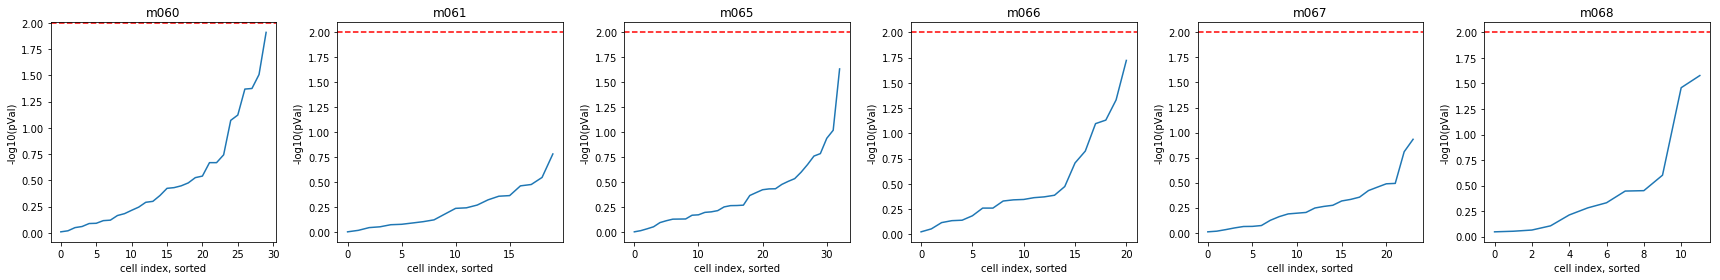

8 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,28,-0.0
1,m061,0,15,-0.0
2,m065,0,17,-0.0
3,m066,0,9,0.0
4,m067,0,9,0.0
5,m068,0,10,-0.0


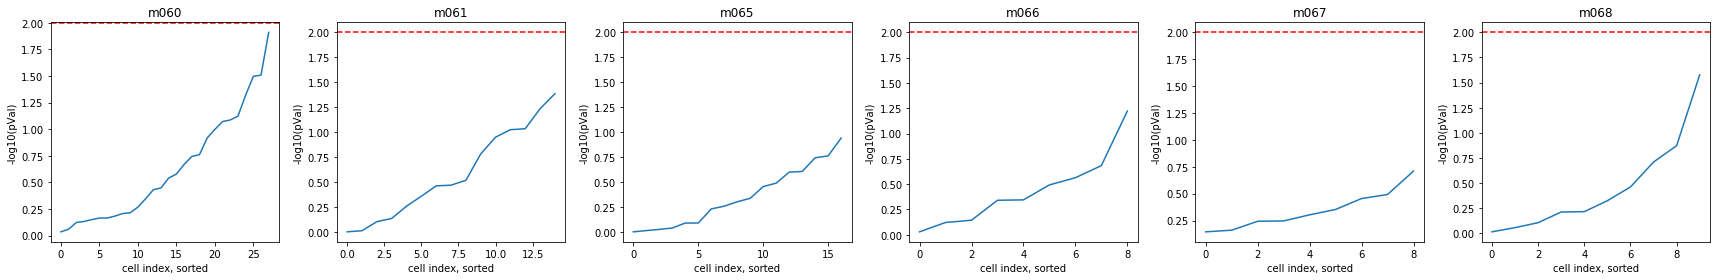

8 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,88,0.00
1,m061,0,46,0.00
2,m065,7,83,4.67
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,0,28,-0.00


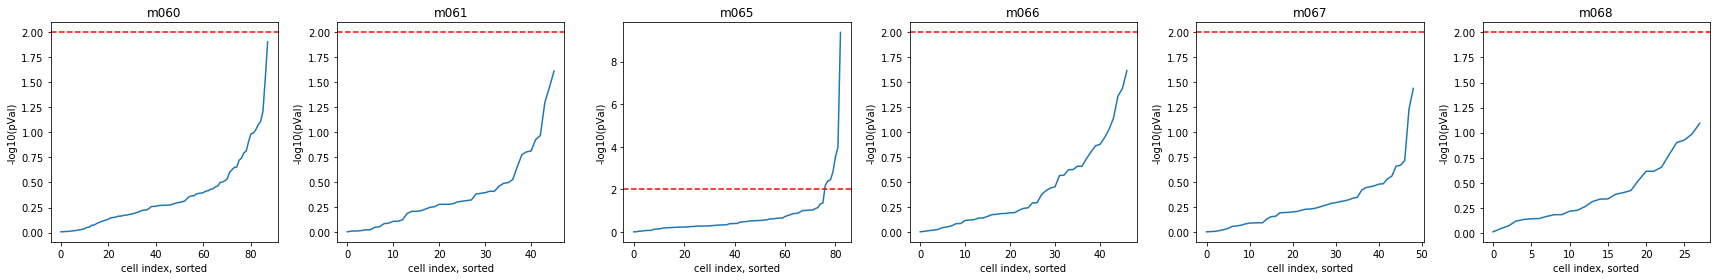

8 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,30,-0.00
1,m061,0,20,0.00
2,m065,1,33,0.55
3,m066,0,21,0.00
4,m067,0,24,0.00
5,m068,0,12,0.00


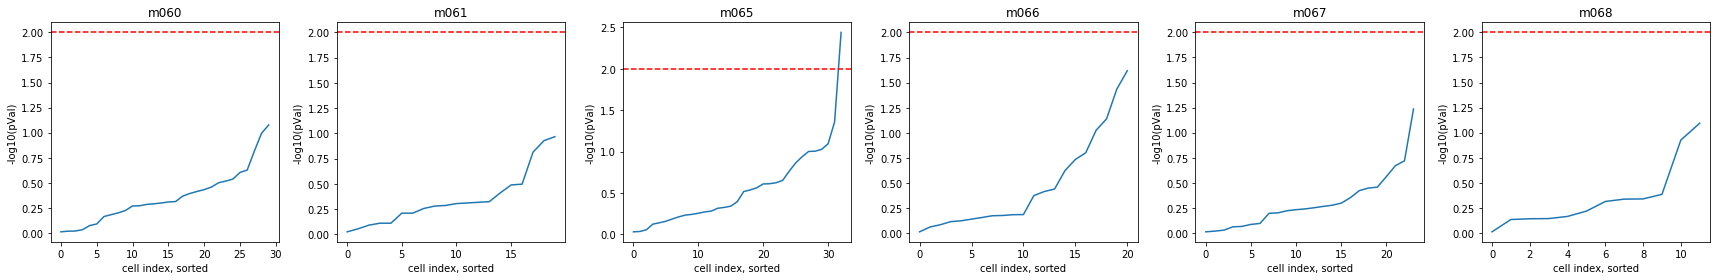

8 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,28,-0.00
1,m061,0,15,-0.00
2,m065,4,17,4.67
3,m066,0,9,0.00
4,m067,0,9,0.00
5,m068,0,10,-0.00


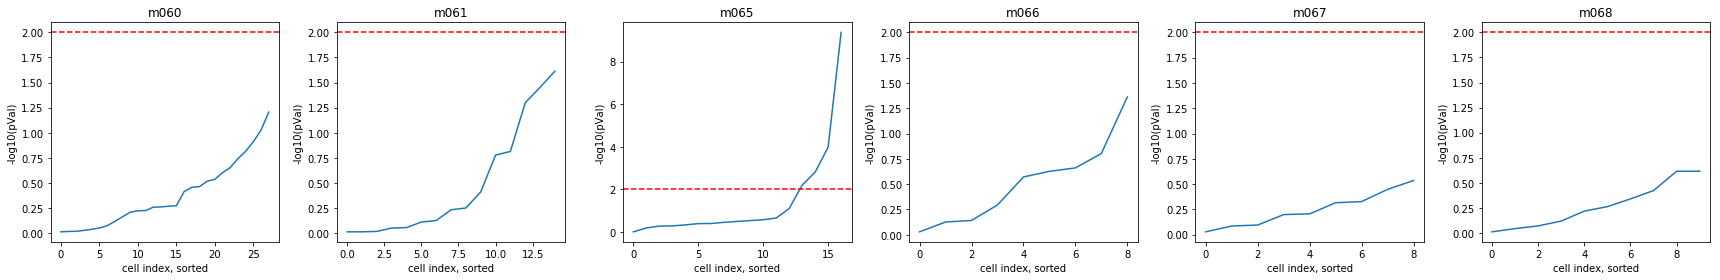

8 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,2,88,0.66
1,m061,1,46,0.43
2,m065,2,83,0.70
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,1,28,0.61


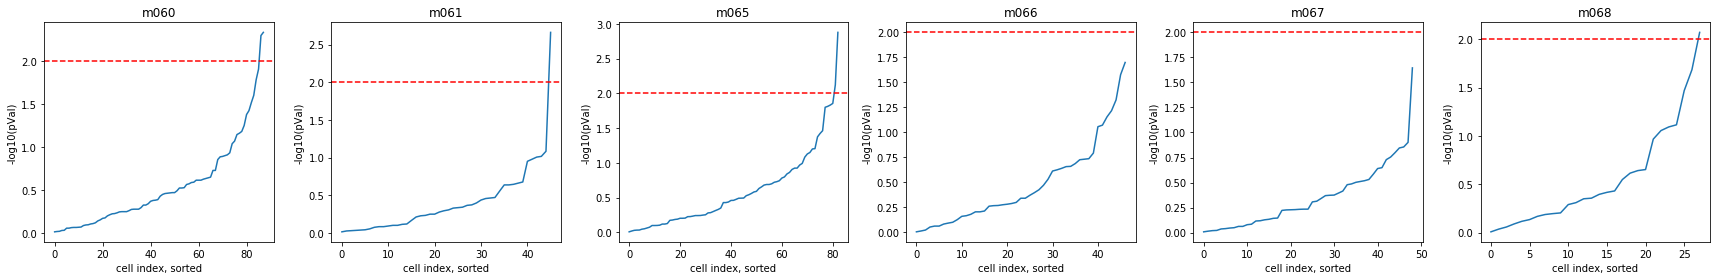

8 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,1,52,0.39
1,m061,1,26,0.64
2,m065,1,43,0.45
3,m066,0,22,-0.00
4,m067,0,38,-0.00
5,m068,0,11,0.00


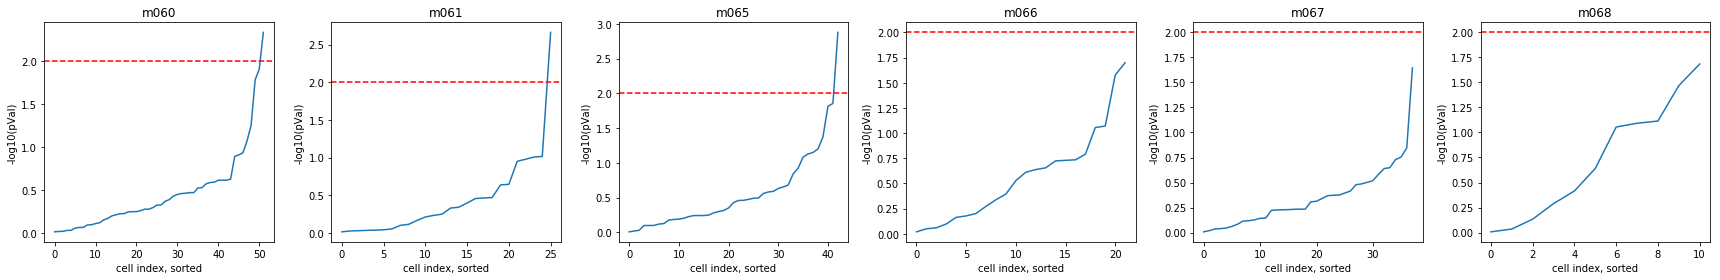

8 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,2,40,1.22
1,m061,0,8,0.00
2,m065,0,21,0.00
3,m066,0,15,-0.00
4,m067,0,13,0.00
5,m068,1,14,0.88


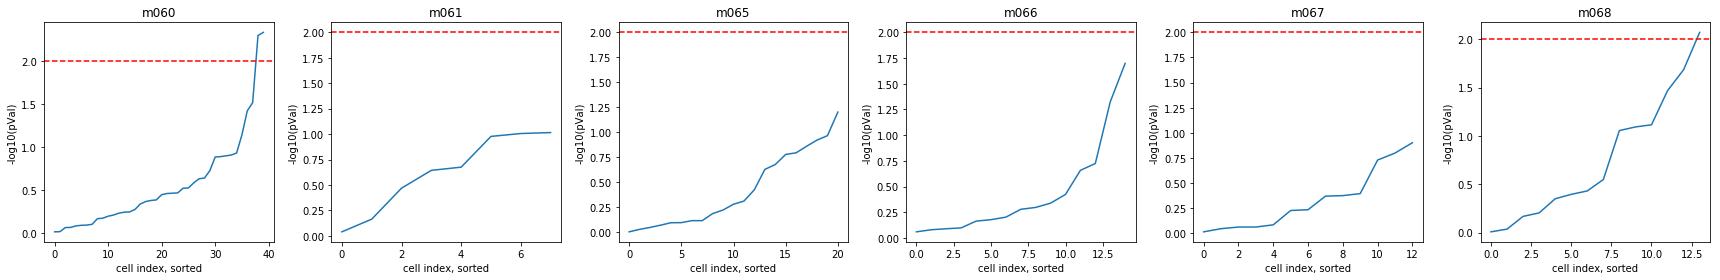

8 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,88,0.00
1,m061,0,46,0.00
2,m065,2,83,0.70
3,m066,0,47,-0.00
4,m067,0,49,0.00
5,m068,1,28,0.61


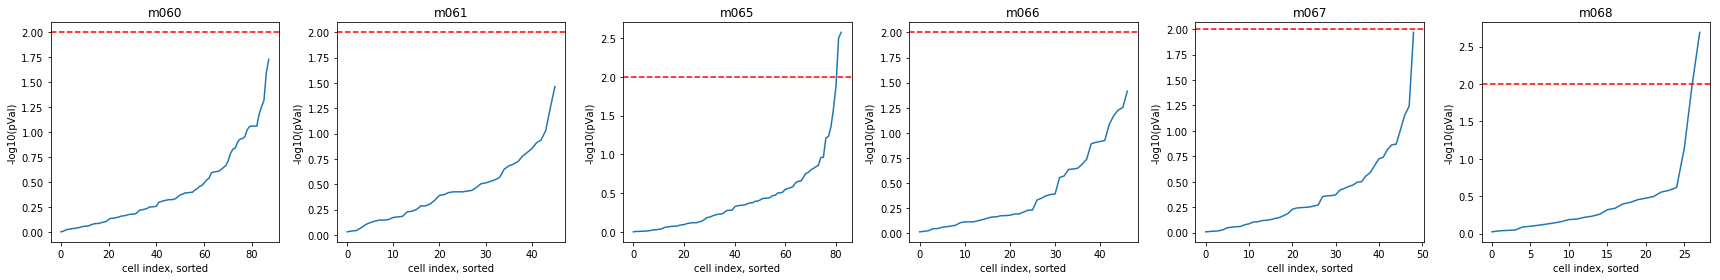

8 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,52,-0.0
1,m061,0,26,-0.0
2,m065,0,43,-0.0
3,m066,0,22,-0.0
4,m067,0,38,-0.0
5,m068,0,11,0.0


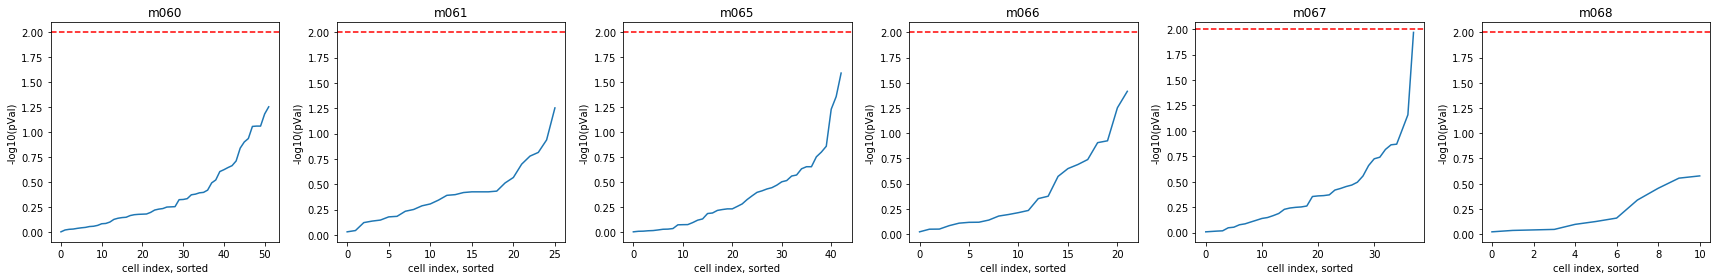

8 ; Significant Cells : Reward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,40,-0.0
1,m061,0,8,0.0
2,m065,0,21,0.0
3,m066,0,15,-0.0
4,m067,0,13,0.0
5,m068,0,14,-0.0


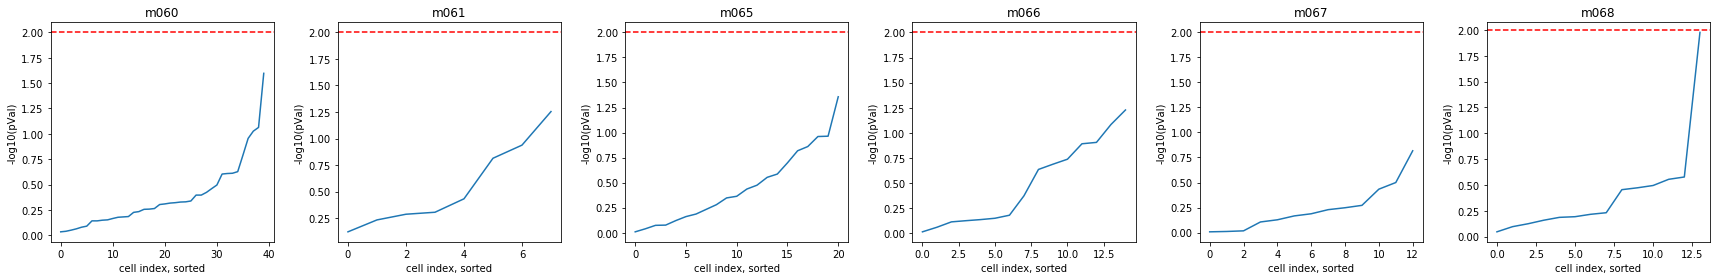

In [22]:
# selector = {"phase" : "Maintenance"}

rezDFDict = {}
for interval in range(6, 9):
    for datatype in ['raw', 'deconv']:
        for condition in ["performance", "direction"]:
            for signCellsName, signCells in significantCellsSelectorDatatype[datatype].items():
    #             print(condition, useSignificant)
                keys = (interval, datatype, condition, signCellsName)
                selector = {"interval" : interval}
                print(keys)
                rezDF = test_mean_time(dataDB, datatype, selector, condition, signCellsMouseDict=signCells)
                rezDFDict[keys] = rezDF

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(merge_df_from_dict(rezDFDict, ['interval', 'datatype', 'condition', 'filter']))

,interval,datatype,condition,filter,mouse,nCellSignificant,nCellTot,pvalPopulation
0,6,raw,performance,None,m060,4,88,1.92
1,6,raw,performance,None,m061,0,46,0.00
2,6,raw,performance,None,m065,0,83,0.00
3,6,raw,performance,None,m066,0,47,-0.00
4,6,raw,performance,None,m067,1,49,0.41
5,6,raw,performance,None,m068,0,28,-0.00
6,6,raw,performance,Maintenance,m060,1,30,0.58
7,6,raw,performance,Maintenance,m061,0,20,0.00
8,6,raw,performance,Maintenance,m065,0,33,-0.00
9,6,raw,performance,Maintenance,m066,0,21,0.00


## 2.1 LRCM discrimination by phase/interval

Calculating mouse m060
Calculating mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; 

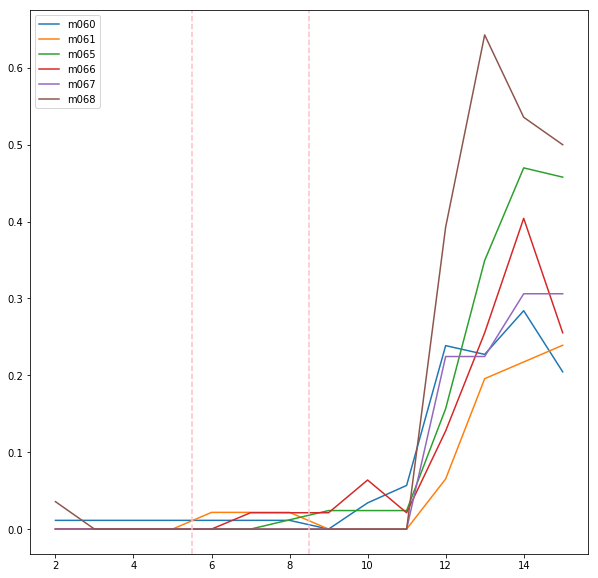

In [18]:
def test_ncells_by_interval(dataDB, queryDict, condition, intervRange, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(figsize=(10,10))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Calculating mouse", mousename)
        
        freqCellSignificant = []
        for iInterv in intervRange:
            selector = {"interval" : iInterv}
        
            means = []
            for condVal in condValues:        
                queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
                means += [metric_by_selector(dataDB, queryDictCond, "mean", "pr", selector, {})]

            nCells = means[0].shape[0]
            _, nCellSignificant, _ = test_quantity(means[0], means[1], pval)
            freqCellSignificant += [nCellSignificant / nCells]
            
        ax.plot(np.array(intervRange)+1, freqCellSignificant, label=mousename)

    ax.axvline(x=5.5, linestyle='--', color='pink')
    ax.axvline(x=8.5, linestyle='--', color='pink')
    plt.legend()
    plt.savefig('interval_freq_significant_cells_'+condition+'.pdf')
    plt.show()
    
queryDict = {"datatype" : "raw", "direction" : "R"}
# queryDict = {"datatype" : "raw", "performance" : "Correct"}
test_ncells_by_interval(dataDB, queryDict, "performance", range(1, 15))

## 2.3 Significant Cell Confusion matrices

In [19]:
def text_different_one(data2D, i):
    dataThis = data2D[i]
    dataOther = np.hstack(data2D[:i] + data2D[i+1:])
    T, p = rstest_twosided(dataThis, dataOther)
    return -np.log10(p)


def text_different(data2D):
    return np.array([text_different_one(data2D, i) for i in range(len(data2D))])


# Calculate confusion matrix
def significance_confusion_matrix(sign2D):
    nCell, nPhase = sign2D.shape  # A boolean array reporting if a given cell is significant in a given phase
    confMat = np.zeros((nPhase, nPhase))
    for i in range(nPhase):
        for j in range(nPhase):
            confMat[i][j] = np.sum(np.logical_and(sign2D[:, i], sign2D[:, j]))
    return confMat


def confusion_matrices_LRCM(queryDict, selector):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 4), tight_layout=True)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print('doing mouse', mousename)

        keys = []
        rezLst = []
        for performance in ['Correct', 'Mistake']:
            for direction in ['L', 'R']:
                keys += [str((performance, direction))]
                queryDictThis = {**queryDict, **{'mousename' : mousename, 'performance' : performance, 'direction' : direction}}
                rezLst += [metric_by_selector(dataDB, queryDictThis, 'mean', 'pr', selector, settings)]
                
        nChannel = len(rezLst[0])
        pVals2D = np.array([text_different([rez[iCh] for rez in rezLst]) for iCh in range(nChannel)])

        # Calculate confusion matrix
        sign2D = pVals2D > 2
        confMat = significance_confusion_matrix(sign2D)

        # Plot confusion matrix
        imshow(fig, ax[iMouse], confMat, limits=[0, nChannel], title=mousename, haveColorBar=True, cmap='jet',
               haveTicks=True, xTicks=keys, yTicks=keys)

    fig.savefig('interval_'+ str(selector["interval"]) +'_significant_cells_confusion.pdf')
    #plt.show()
    plt.close()

In [20]:
for iInterv in range(5, 10):
    confusion_matrices_LRCM({"datatype" : "deconv"}, {"interval" : iInterv})

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour 

# 3. Scalar metric tests

**Goal**: Evaluate predictive power for several metrics
* Stretch hypothesis: Legendre Basis (try several bases individually up to 6)
* Synchronization hypothesis: AvgCorr, H

## Table

In [81]:
%%time
dataDB.verbose = False

#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
sweepDict = {
    "datatype": ["deconv"],
    "performance": ["Correct", "Mistake", "All"],
#     "direction": ["L", "R", "All"]
}
# selector = {"phase" : "Maintenance"}
selector = {"interval" : 9}

table_lib.table_discriminate_behavior(dataDB, selector, "direction",
                                      sweepDict,
                                      "mean",
                                      trgDimOrder="r",
                                      settings=settings,
                                      multiplexKey="mousename",
                                      channelFilter=None)

,datatype,performance,mu(R),mu(L),-logp(R->L)
0,deconv,Correct,0.092590,0.090466,0.221560
1,deconv,Mistake,0.084383,0.094697,1.121315
2,deconv,All,0.091056,0.091076,0.169473


CPU times: user 464 ms, sys: 3.82 ms, total: 468 ms
Wall time: 465 ms


## Violins

For ('Mistake', 'Correct') of data size (114, 434) rank-sum-test is 0.0007104739231471268


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


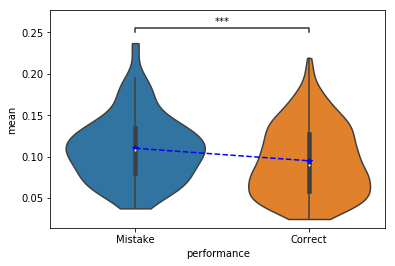

In [22]:
def binary_test_phase(dataDB, queryDict, condition, selector, metricName, settings):
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    
    rezLst = []
    for condVal in condValues:
        queryDictCond = {**queryDict, **{condition : condVal}}
        rezLst += [metric_by_selector(dataDB, queryDictCond, metricName, "r", selector, {})]
        
    fig, ax = plt.subplots()
    plots_lib.plot_labeled_violins(ax, rezLst, condValues, condition, metricName,
                                   joinMeans=True, haveLog=False, sigTestPairs=[(0,1)])
    
    
#settings = {"serial" : True, "metricSettings" : {"metric" : num_sample}}
settings = {"serial" : True, "metricSettings" : {}}
queryDict = {"datatype" : "deconv", "direction" : "L"}

binary_test_phase(dataDB, queryDict, "performance", {"interval" : 9}, "mean", settings)
#binary_test_phase(dataDB, queryDict, "direction", ["L", "R"], "Maintenance", settings)

# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

In [3]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"serial": True, "metricSettings": None}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings)

rez

NameError: name 'plots_lib' is not defined

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)